<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install catboost
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


<ipython-input-18-2dde29d8c1d1>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = current_prediction


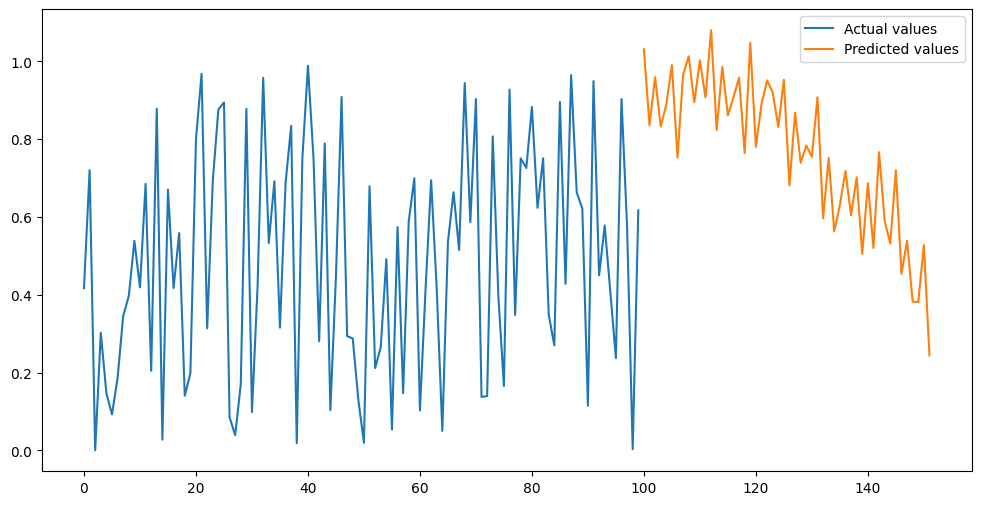

In [18]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# предположим, у вас есть временной ряд:
data = pd.Series(np.random.rand(100))

# сохраняем исходное значение временного ряда, которое будет утеряно при дифференцировании
first_value = data[0]

# применяем дифференцирование
data_diff = data.diff().dropna()

# определите количество лагов и шагов прогнозирования
lags = 52
steps = 52

# создайте матрицу признаков на основе лагов
X = pd.concat([data_diff.shift(i) for i in range(lags, 0, -1)], axis=1).dropna()
X.columns = ['lag_' + str(i) for i in range(1, lags + 1)]

# целевая переменная будет текущим значением дифференцированного временного ряда
y = data_diff[X.index]

# создайте модель
model = CatBoostRegressor(random_state=963, silent=True)

# обучите модель
model.fit(X, y)

# сделайте рекурсивные многошаговые прогнозы
predictions = []
current_input = X.iloc[-1, :].values

for i in range(steps):
    current_prediction = model.predict(current_input.reshape(1, -1))
    predictions.append(current_prediction)

    # обновляем входные данные, заменяя нашу последнюю точку данных прогнозом
    current_input = np.roll(current_input, shift=-1)
    current_input[-1] = current_prediction

pred_diff = np.array(predictions)


# применяем cumsum(), чтобы вернуться к исходным значениям
pred_prob = pd.Series(pred_diff.flatten()).cumsum() + first_value
# создаем индексы для прогнозов
pred_index = pd.RangeIndex(start=data.index[-1] + 1, stop=data.index[-1] + steps + 1)

# создаем серию прогнозов с правильными индексами
pred_series = pd.Series(pred_prob.tolist(), index=pred_index)

# строим график реальных данных и прогнозов
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual values')
plt.plot(pred_series, label='Predicted values')
plt.legend()
plt.show()


In [19]:
data

0     0.417022
1     0.720324
2     0.000114
3     0.302333
4     0.146756
        ...   
95    0.237027
96    0.903380
97    0.573679
98    0.002870
99    0.617145
Length: 100, dtype: float64

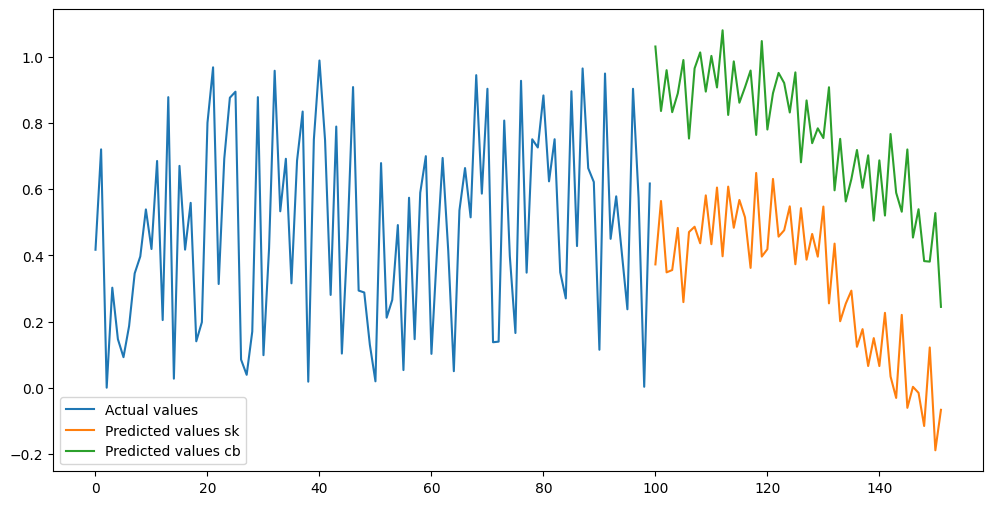

In [20]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import matplotlib.pyplot as plt

# предположим, у вас есть временной ряд:
# data = pd.Series(np.random.rand(100))

forecaster_cb_prob = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_state=963,silent=True),
    lags=52,
    differentiation=1
)

# предположим, что end_train = 80
end_train = 80

forecaster_cb_prob.fit(y=data)
pred_prob = forecaster_cb_prob.predict(steps=52)

# строим график реальных данных и прогнозов
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual values')
pred_prob.plot(label='Predicted values sk')
pred_series.plot(label='Predicted values cb')
plt.legend()
plt.show()

In [21]:
pred_prob.head(5)

100    0.372702
101    0.564260
102    0.348674
103    0.355660
104    0.482933
Name: pred, dtype: float64

In [22]:
pred_series.head(5)

100    1.031112
101    0.836250
102    0.959639
103    0.832731
104    0.889524
dtype: float64

In [23]:
X

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
53  0.303302 -0.720210  0.302218 -0.155577 -0.054417  0.093922  0.159301   
54 -0.720210  0.302218 -0.155577 -0.054417  0.093922  0.159301  0.051207   
55  0.302218 -0.155577 -0.054417  0.093922  0.159301  0.051207  0.142049   
56 -0.155577 -0.054417  0.093922  0.159301  0.051207  0.142049 -0.119622   
57 -0.054417  0.093922  0.159301  0.051207  0.142049 -0.119622  0.266025   
58  0.093922  0.159301  0.051207  0.142049 -0.119622  0.266025 -0.480767   
59  0.159301  0.051207  0.142049 -0.119622  0.266025 -0.480767  0.673665   
60  0.051207  0.142049 -0.119622  0.266025 -0.480767  0.673665 -0.850730   
61  0.142049 -0.119622  0.266025 -0.480767  0.673665 -0.850730  0.643080   
62 -0.119622  0.266025 -0.480767  0.673665 -0.850730  0.643080 -0.253163   
63  0.266025 -0.480767  0.673665 -0.850730  0.643080 -0.253163  0.141385   
64 -0.480767  0.673665 -0.850730  0.643080 -0.253163  0.141385 -0.418303   
65  0.673665 -0.850730  0.643080 -0.253163  0.141385 -0.418303  0.057715   
66 -0.850730  0.643080 -0.253163  0.141385 -0.418303  0.057715  0.602643   
67  0.643080 -0.253163  0.141385 -0.418303  0.057715  0.602643  0.167517   
68 -0.253163  0.141385 -0.418303  0.057715  0.602643  0.167517 -0.654837   
69  0.141385 -0.418303  0.057715  0.602643  0.167517 -0.654837  0.378898   
70 -0.418303  0.057715  0.602643  0.167517 -0.654837  0.378898  0.184067   
71  0.057715  0.602643  0.167517 -0.654837  0.378898  0.184067  0.018218   
72  0.602643  0.167517 -0.654837  0.378898  0.184067  0.018218 -0.809562   
73  0.167517 -0.654837  0.378898  0.184067  0.018218 -0.809562 -0.045989   
74 -0.654837  0.378898  0.184067  0.018218 -0.809562 -0.045989  0.130776   
75  0.378898  0.184067  0.018218 -0.809562 -0.045989  0.130776  0.708312   
76  0.184067  0.018218 -0.809562 -0.045989  0.130776  0.708312 -0.779796   
77  0.018218 -0.809562 -0.045989  0.130776  0.708312 -0.779796  0.322761   
78 -0.809562 -0.045989  0.130776  0.708312 -0.779796  0.322761  0.536782   
79 -0.045989  0.130776  0.708312 -0.779796  0.322761  0.536782 -0.424724   
80  0.130776  0.708312 -0.779796  0.322761  0.536782 -0.424724  0.158712   
81  0.708312 -0.779796  0.322761  0.536782 -0.424724  0.158712 -0.376361   
82 -0.779796  0.322761  0.536782 -0.424724  0.158712 -0.376361  0.370985   
83  0.322761  0.536782 -0.424724  0.158712 -0.376361  0.370985  0.148125   
84  0.536782 -0.424724  0.158712 -0.376361  0.370985  0.148125 -0.816337   
85 -0.424724  0.158712 -0.376361  0.370985  0.148125 -0.816337  0.731856   
86  0.158712 -0.376361  0.370985  0.148125 -0.816337  0.731856  0.238717   
87 -0.376361  0.370985  0.148125 -0.816337  0.731856  0.238717 -0.240695   
88  0.370985  0.148125 -0.816337  0.731856  0.238717 -0.240695 -0.467722   
89  0.148125 -0.816337  0.731856  0.238717 -0.240695 -0.467722  0.508835   
90 -0.816337  0.731856  0.238717 -0.240695 -0.467722  0.508835 -0.686053   
91  0.731856  0.238717 -0.240695 -0.467722  0.508835 -0.686053  0.344668   
92  0.238717 -0.240695 -0.467722  0.508835 -0.686053  0.344668  0.460702   
93 -0.240695 -0.467722  0.508835 -0.686053  0.344668  0.460702 -0.614981   
94 -0.467722  0.508835 -0.686053  0.344668  0.460702 -0.614981 -0.005839   
95  0.508835 -0.686053  0.344668  0.460702 -0.614981 -0.005839 -0.157747   
96 -0.686053  0.344668  0.460702 -0.614981 -0.005839 -0.157747 -0.110662   
97  0.344668  0.460702 -0.614981 -0.005839 -0.157747 -0.110662  0.659469   
98  0.460702 -0.614981 -0.005839 -0.157747 -0.110662  0.659469 -0.467207   
99 -0.614981 -0.005839 -0.157747 -0.110662  0.659469 -0.467207  0.053919   

       lag_8     lag_9    lag_10  ...    lag_43    lag_44    lag_45    lag_46  \
53  0.051207  0.142049 -0.119622  ...  0.508835 -0.686053  0.344668  0.460702   
54  0.142049 -0.119622  0.266025  ... -0.686053  0.344668  0.460702 -0.614981   
55 -0.119622  0.266025 -0.480767  ...  0.344668  0.460702 -0.614981 -0.005839   
56  0.266025 -0.480767  0.673665  

In [24]:
y

53    0.053919
54    0.226026
55   -0.438211
56    0.520755
57   -0.427389
58    0.442577
59    0.110453
60   -0.597424
61    0.311722
62    0.280344
63   -0.280221
64   -0.364226
65    0.485943
66    0.127898
67   -0.148906
68    0.429706
69   -0.358040
70    0.316847
71   -0.765927
72    0.001802
73    0.668115
74   -0.409714
75   -0.232323
76    0.762154
77   -0.579743
78    0.403046
79   -0.024814
80    0.157308
81   -0.259634
82    0.127270
83   -0.402044
84   -0.078970
85    0.625958
86   -0.467795
87    0.536749
88   -0.301399
89   -0.041746
90   -0.506950
91    0.834743
92   -0.499577
93    0.128477
94   -0.170253
95   -0.171110
96    0.666353
97   -0.329700
98   -0.570809
99    0.614275
dtype: float64

In [25]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster_cb_prob.create_train_X_y(
                       y=data
                   )

display(X_train)
# display(y_train.head(3))

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
53 -0.467207  0.659469 -0.110662 -0.157747 -0.005839 -0.614981  0.460702   
54  0.053919 -0.467207  0.659469 -0.110662 -0.157747 -0.005839 -0.614981   
55  0.226026  0.053919 -0.467207  0.659469 -0.110662 -0.157747 -0.005839   
56 -0.438211  0.226026  0.053919 -0.467207  0.659469 -0.110662 -0.157747   
57  0.520755 -0.438211  0.226026  0.053919 -0.467207  0.659469 -0.110662   
58 -0.427389  0.520755 -0.438211  0.226026  0.053919 -0.467207  0.659469   
59  0.442577 -0.427389  0.520755 -0.438211  0.226026  0.053919 -0.467207   
60  0.110453  0.442577 -0.427389  0.520755 -0.438211  0.226026  0.053919   
61 -0.597424  0.110453  0.442577 -0.427389  0.520755 -0.438211  0.226026   
62  0.311722 -0.597424  0.110453  0.442577 -0.427389  0.520755 -0.438211   
63  0.280344  0.311722 -0.597424  0.110453  0.442577 -0.427389  0.520755   
64 -0.280221  0.280344  0.311722 -0.597424  0.110453  0.442577 -0.427389   
65 -0.364226 -0.280221  0.280344  0.311722 -0.597424  0.110453  0.442577   
66  0.485943 -0.364226 -0.280221  0.280344  0.311722 -0.597424  0.110453   
67  0.127898  0.485943 -0.364226 -0.280221  0.280344  0.311722 -0.597424   
68 -0.148906  0.127898  0.485943 -0.364226 -0.280221  0.280344  0.311722   
69  0.429706 -0.148906  0.127898  0.485943 -0.364226 -0.280221  0.280344   
70 -0.358040  0.429706 -0.148906  0.127898  0.485943 -0.364226 -0.280221   
71  0.316847 -0.358040  0.429706 -0.148906  0.127898  0.485943 -0.364226   
72 -0.765927  0.316847 -0.358040  0.429706 -0.148906  0.127898  0.485943   
73  0.001802 -0.765927  0.316847 -0.358040  0.429706 -0.148906  0.127898   
74  0.668115  0.001802 -0.765927  0.316847 -0.358040  0.429706 -0.148906   
75 -0.409714  0.668115  0.001802 -0.765927  0.316847 -0.358040  0.429706   
76 -0.232323 -0.409714  0.668115  0.001802 -0.765927  0.316847 -0.358040   
77  0.762154 -0.232323 -0.409714  0.668115  0.001802 -0.765927  0.316847   
78 -0.579743  0.762154 -0.232323 -0.409714  0.668115  0.001802 -0.765927   
79  0.403046 -0.579743  0.762154 -0.232323 -0.409714  0.668115  0.001802   
80 -0.024814  0.403046 -0.579743  0.762154 -0.232323 -0.409714  0.668115   
81  0.157308 -0.024814  0.403046 -0.579743  0.762154 -0.232323 -0.409714   
82 -0.259634  0.157308 -0.024814  0.403046 -0.579743  0.762154 -0.232323   
83  0.127270 -0.259634  0.157308 -0.024814  0.403046 -0.579743  0.762154   
84 -0.402044  0.127270 -0.259634  0.157308 -0.024814  0.403046 -0.579743   
85 -0.078970 -0.402044  0.127270 -0.259634  0.157308 -0.024814  0.403046   
86  0.625958 -0.078970 -0.402044  0.127270 -0.259634  0.157308 -0.024814   
87 -0.467795  0.625958 -0.078970 -0.402044  0.127270 -0.259634  0.157308   
88  0.536749 -0.467795  0.625958 -0.078970 -0.402044  0.127270 -0.259634   
89 -0.301399  0.536749 -0.467795  0.625958 -0.078970 -0.402044  0.127270   
90 -0.041746 -0.301399  0.536749 -0.467795  0.625958 -0.078970 -0.402044   
91 -0.506950 -0.041746 -0.301399  0.536749 -0.467795  0.625958 -0.078970   
92  0.834743 -0.506950 -0.041746 -0.301399  0.536749 -0.467795  0.625958   
93 -0.499577  0.834743 -0.506950 -0.041746 -0.301399  0.536749 -0.467795   
94  0.128477 -0.499577  0.834743 -0.506950 -0.041746 -0.301399  0.536749   
95 -0.170253  0.128477 -0.499577  0.834743 -0.506950 -0.041746 -0.301399   
96 -0.171110 -0.170253  0.128477 -0.499577  0.834743 -0.506950 -0.041746   
97  0.666353 -0.171110 -0.170253  0.128477 -0.499577  0.834743 -0.506950   
98 -0.329700  0.666353 -0.171110 -0.170253  0.128477 -0.499577  0.834743   
99 -0.570809 -0.329700  0.666353 -0.171110 -0.170253  0.128477 -0.499577   

       lag_8     lag_9    lag_10  ...    lag_43    lag_44    lag_45    lag_46  \
53  0.344668 -0.686053  0.508835  ... -0.119622  0.142049  0.051207  0.159301   
54  0.460702  0.344668 -0.686053  ...  0.266025 -0.119622  0.142049  0.051207   
55 -0.614981  0.460702  0.344668  ... -0.480767  0.266025 -0.119622  0.142049   
56 -0.005839 -0.614981  0.460702  

In [26]:
display(y_train.head)

<bound method NDFrame.head of 53    0.053919
54    0.226026
55   -0.438211
56    0.520755
57   -0.427389
58    0.442577
59    0.110453
60   -0.597424
61    0.311722
62    0.280344
63   -0.280221
64   -0.364226
65    0.485943
66    0.127898
67   -0.148906
68    0.429706
69   -0.358040
70    0.316847
71   -0.765927
72    0.001802
73    0.668115
74   -0.409714
75   -0.232323
76    0.762154
77   -0.579743
78    0.403046
79   -0.024814
80    0.157308
81   -0.259634
82    0.127270
83   -0.402044
84   -0.078970
85    0.625958
86   -0.467795
87    0.536749
88   -0.301399
89   -0.041746
90   -0.506950
91    0.834743
92   -0.499577
93    0.128477
94   -0.170253
95   -0.171110
96    0.666353
97   -0.329700
98   -0.570809
99    0.614275
Name: y, dtype: float64>

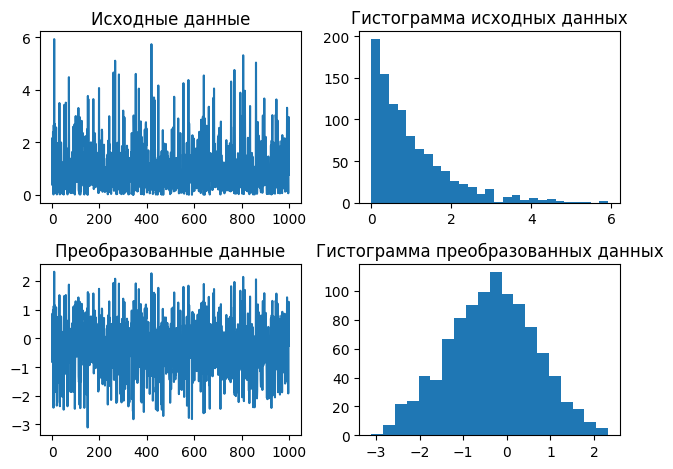

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


# Генерация данных с экспоненциальным распределением
exponential_data = np.random.exponential(scale=1, size=1000)

# Построение графика исходных данных
plt.subplot(2, 2, 1)
plt.plot(exponential_data)
plt.title("Исходные данные")

# Построение гистограммы для исходных данных
plt.subplot(2, 2, 2)
plt.hist(exponential_data, bins='auto')
plt.title("Гистограмма исходных данных")

# Применение преобразования Бокса-Кокса
transformed_data, lambda_value = stats.boxcox(exponential_data)

# Построение графика преобразованных данных
plt.subplot(2, 2, 3)
plt.plot(transformed_data)
plt.title("Преобразованные данные")

# Построение гистограммы для преобразованных данных
plt.subplot(2, 2, 4)
plt.hist(transformed_data, bins='auto')
plt.title("Гистограмма преобразованных данных")

# Отображение графиков
plt.tight_layout()
plt.show()

   Year  Consumption  Income  GDP  Unemployment  Inflation
0  2016          100      50  200           5.0        2.0
1  2017          110      55  210           4.8        2.5
2  2018          120      60  220           4.5        2.2
3  2019          130      65  230           4.2        2.8
4  2020          140      70  240           4.0        2.3


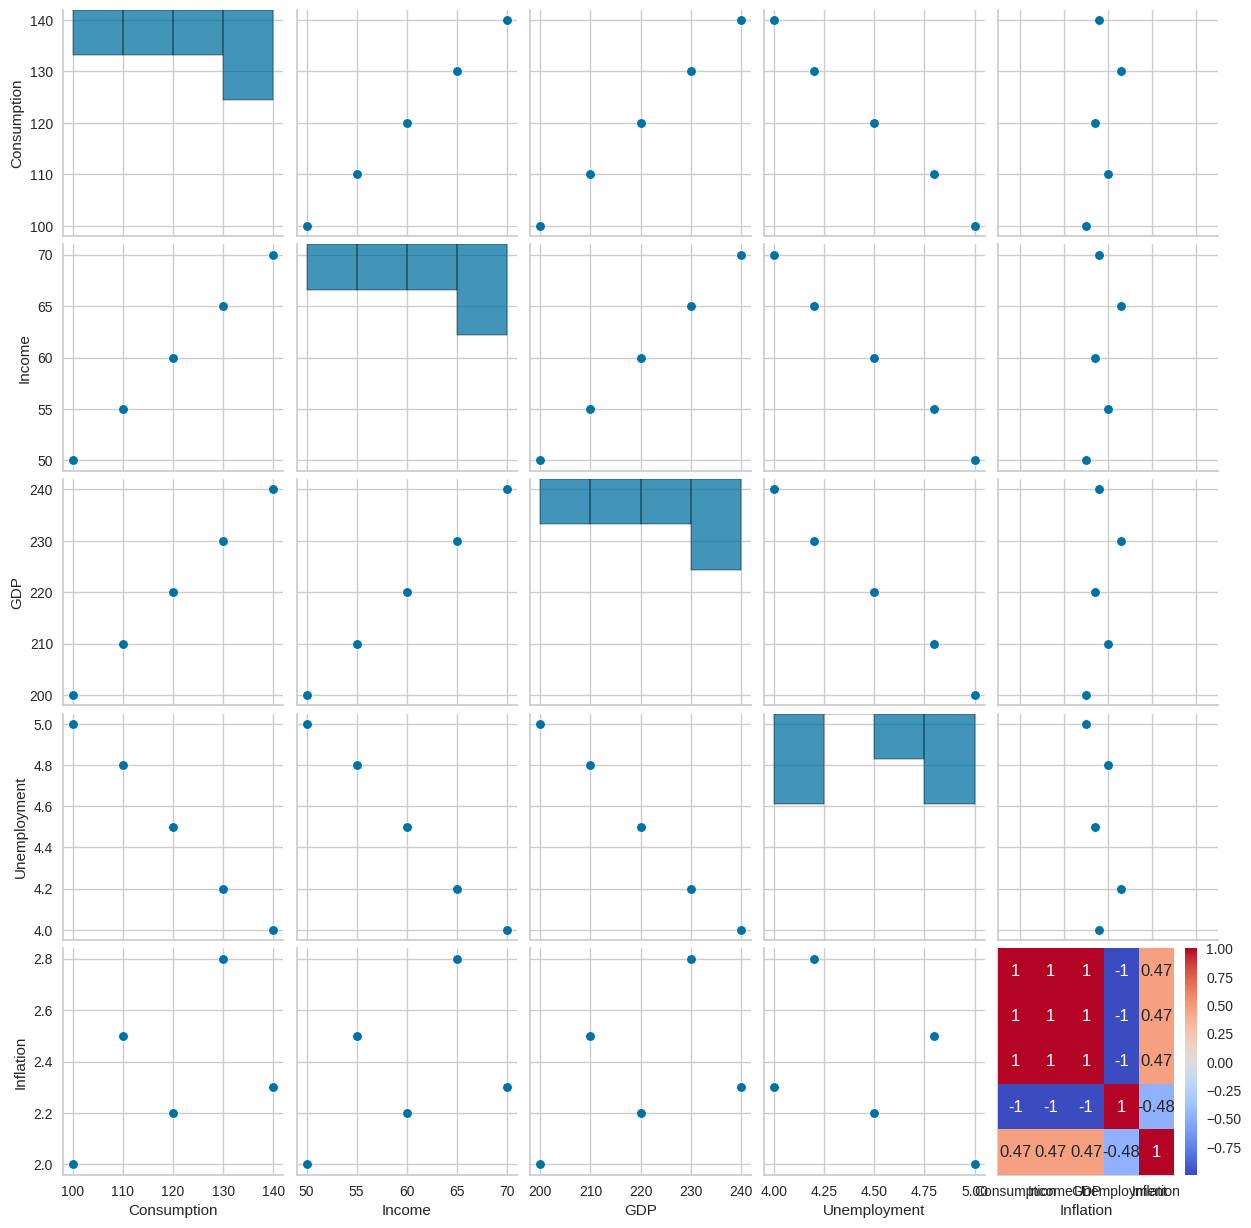

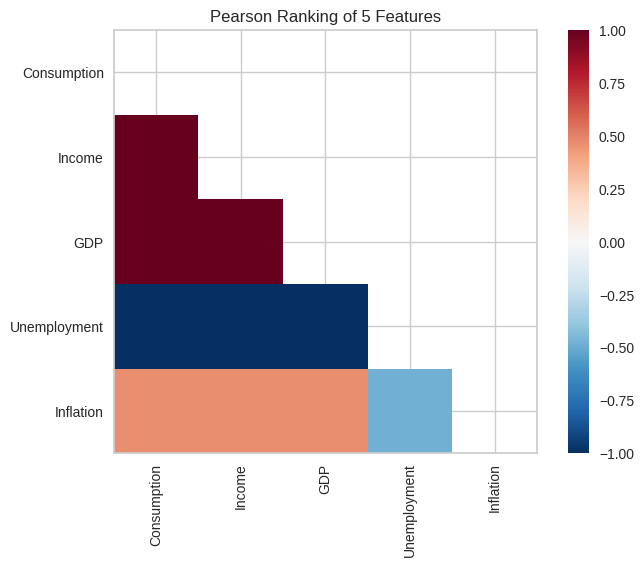

<Axes: title={'center': 'Pearson Ranking of 5 Features'}>

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.features import Rank2D

# Создание словаря с данными
data = {
    'Year': [2016, 2017, 2018, 2019, 2020],
    'Consumption': [100, 110, 120, 130, 140],
    'Income': [50, 55, 60, 65, 70],
    'GDP': [200, 210, 220, 230, 240],
    'Unemployment': [5.0, 4.8, 4.5, 4.2, 4.0],
    'Inflation': [2.0, 2.5, 2.2, 2.8, 2.3]
}

# Создание DataFrame из словаря
us_change = pd.DataFrame(data)

# Вывод набора данных
print(us_change)

# Создание матрицы парных диаграмм
sns.pairplot(us_change.iloc[:, 1:])  # Исключаем столбец "Year" из анализа

# Вычисление коэффициентов корреляции
correlation_matrix = us_change.iloc[:, 1:].corr()

# Визуализация коэффициентов корреляции
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
features = us_change.columns[1:]
X = us_change.iloc[:, 1:].values
visualizer = Rank2D(features=features, algorithm='pearson')
visualizer.fit(X)
visualizer.transform(X)
visualizer.show()

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Создание массивов зависимой переменной и независимой переменной
y = np.array([1, 2, 3, 4, 5])
X = np.array([[2], [3], [3], [8], [10]])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

# Вывод коэффициентов модели
print("Коэффициент наклона (slope):", model.coef_)
print("Смещение (intercept):", model.intercept_)

Коэффициент наклона (slope): [0.41338583]
Смещение (intercept): 0.8503937007874014


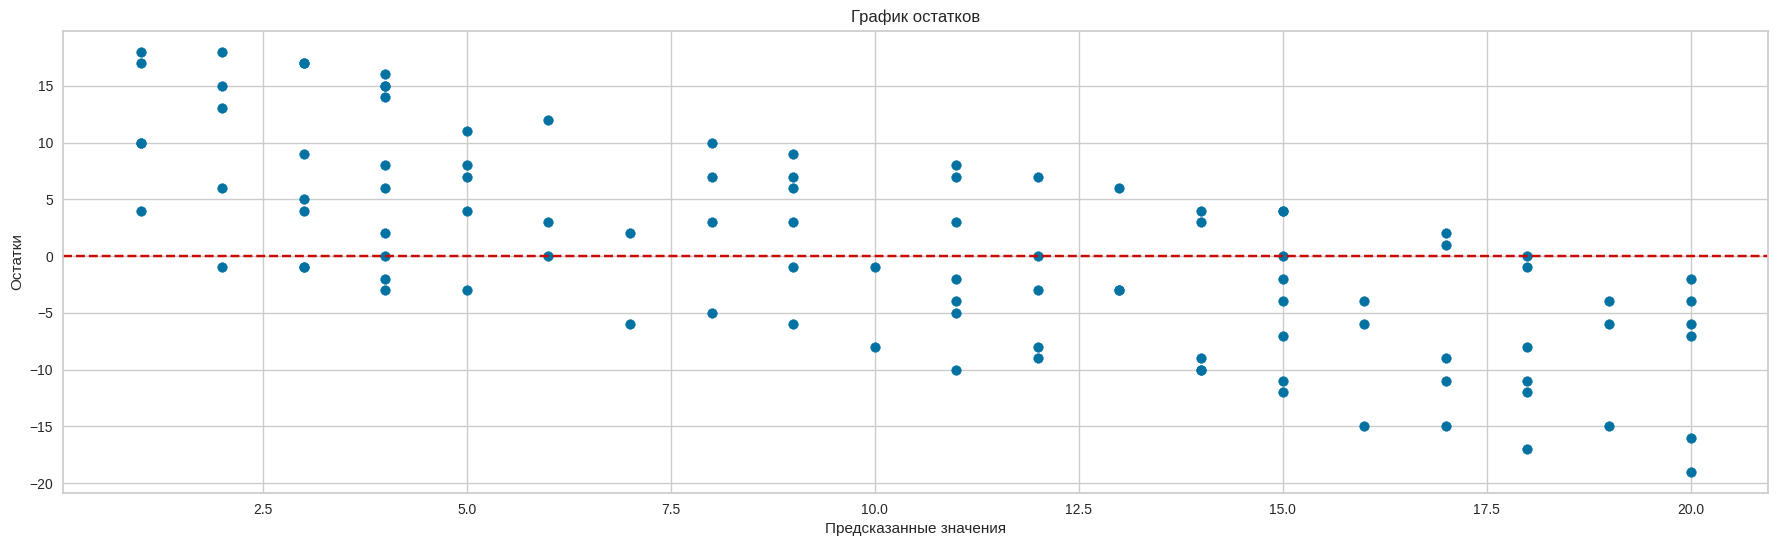

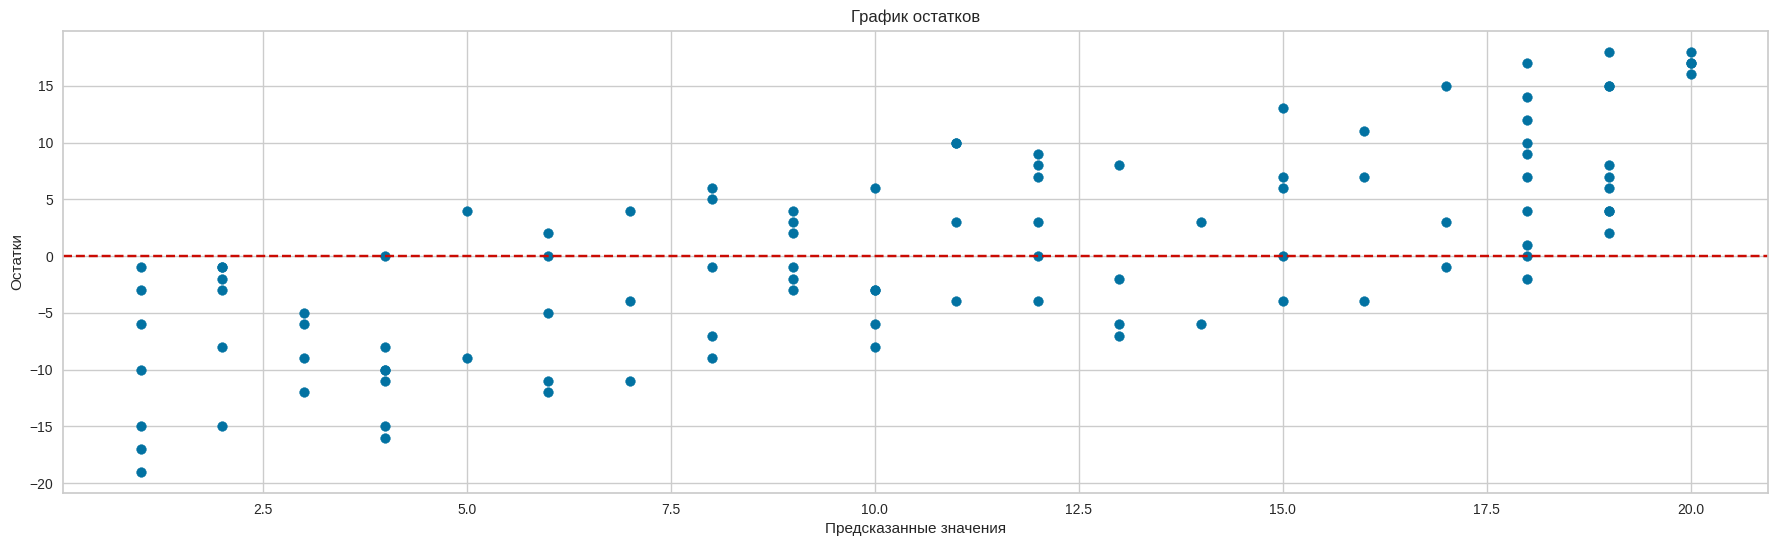

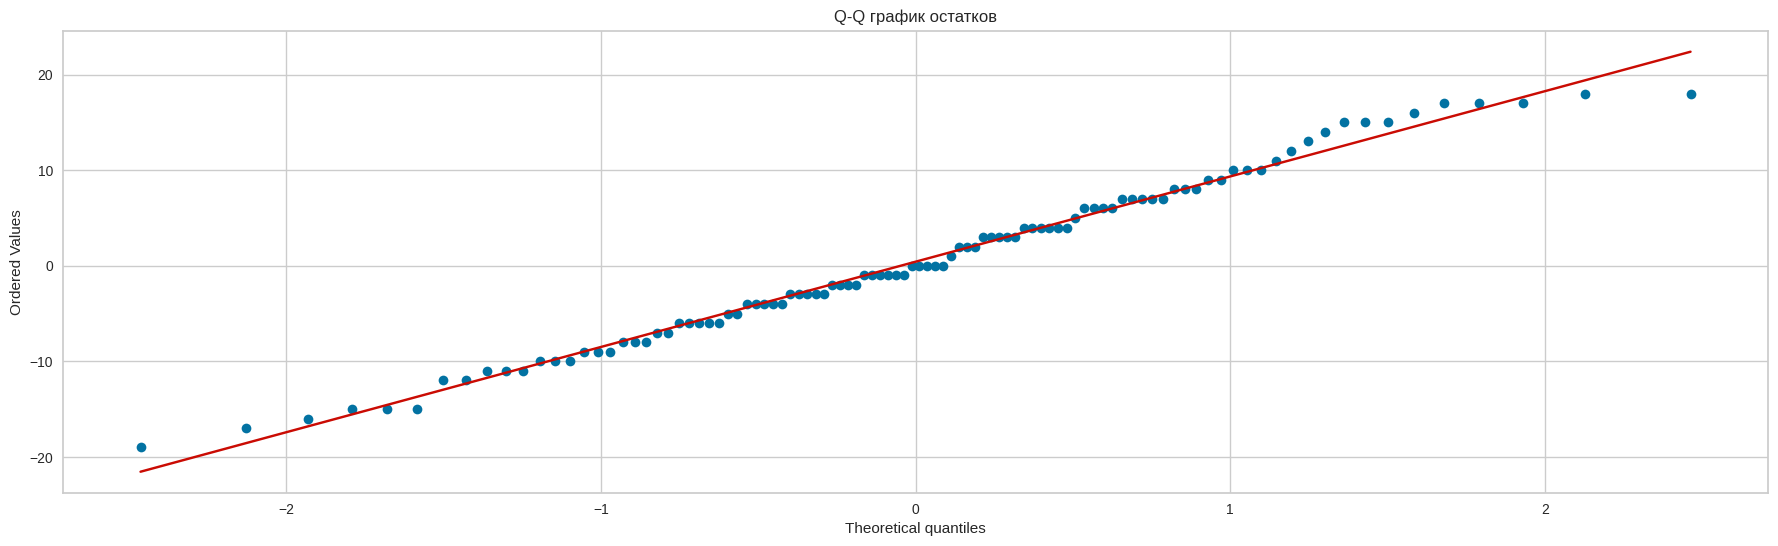

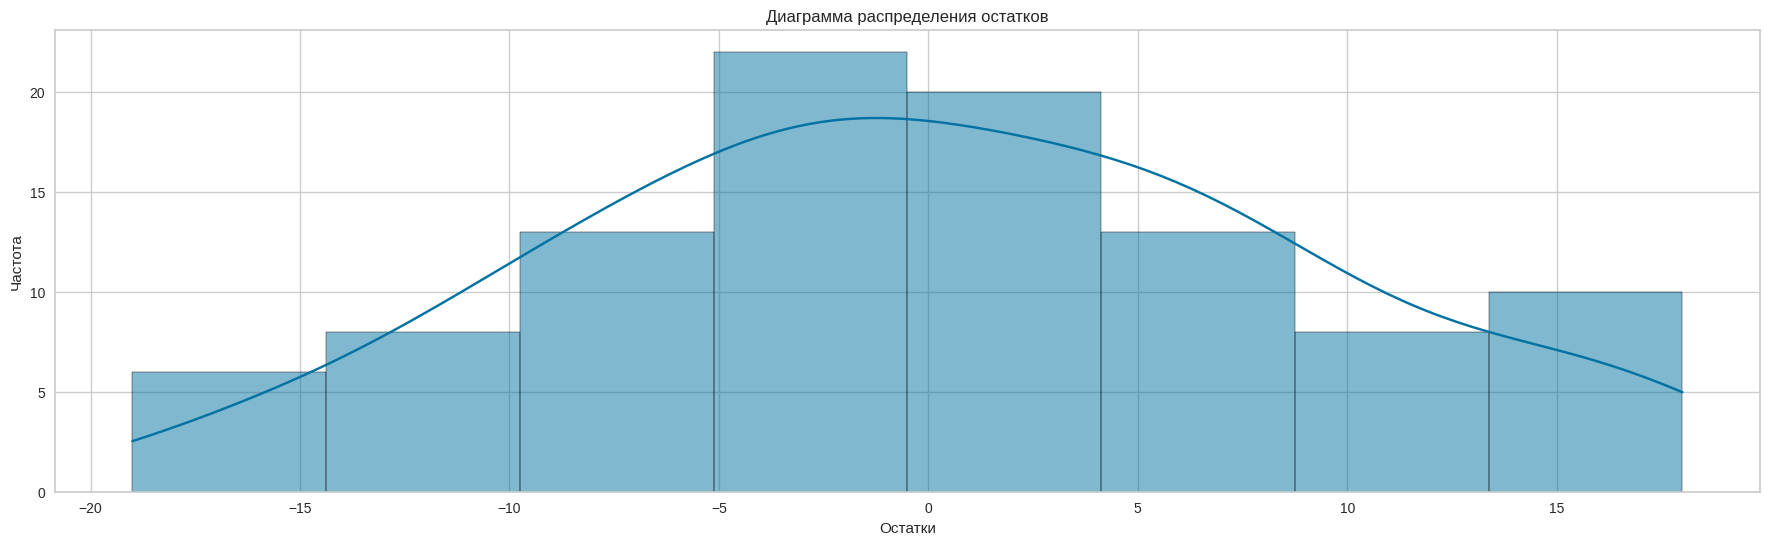

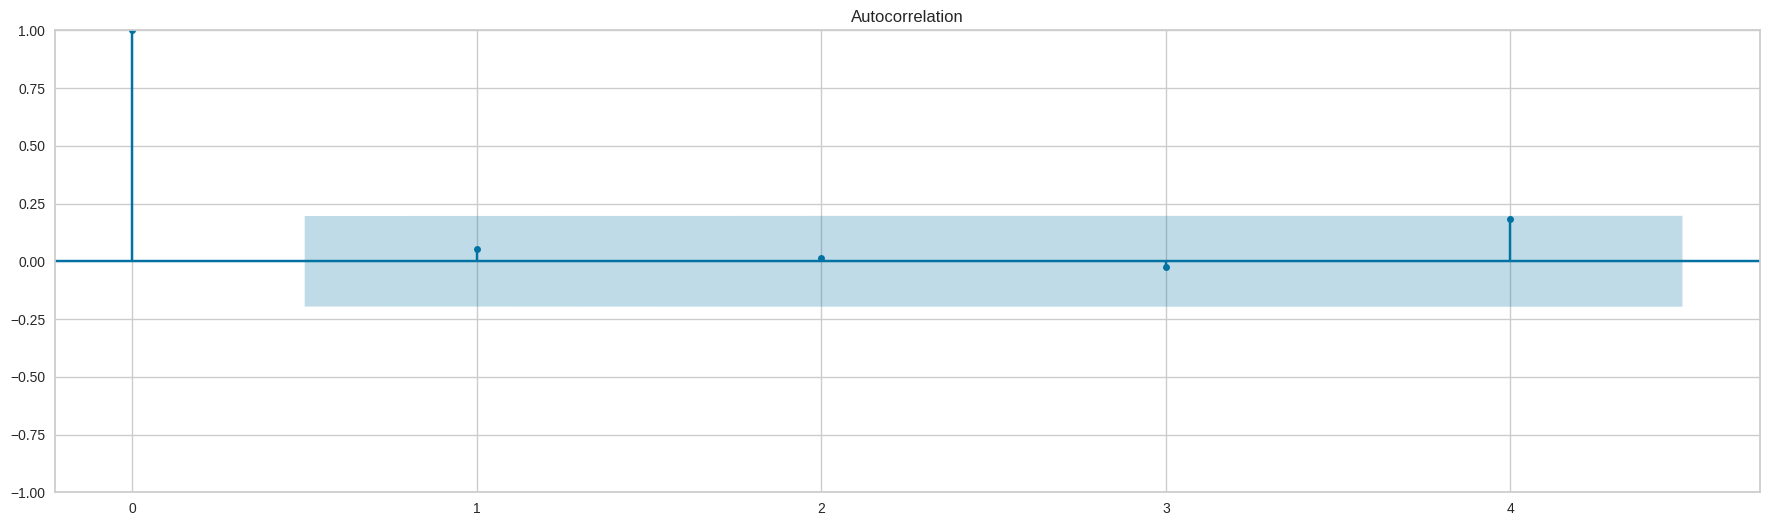

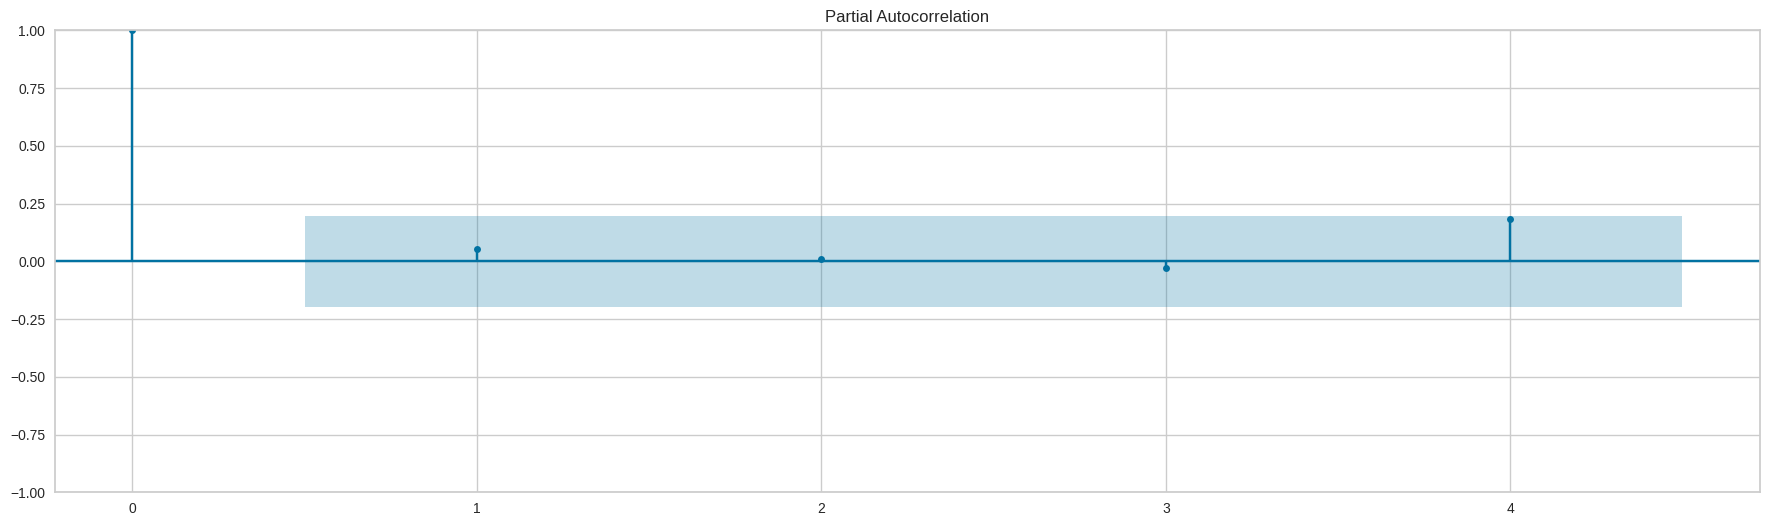


Остатки временного ряда распределены согласно нормальному закону
Статистика теста Шапиро-Уилка : 0.9849511981010437
p-value Шапиро-Уилка : 0.3150275945663452

Тест Бокса-Пирса (BP) и Льюнга-Бокса (LB) на определение шума в остатках
      lb_stat  lb_pvalue    bp_stat  bp_pvalue     result
1    0.270086   0.603274   0.262142   0.608652  белый шум
2    0.286147   0.866691   0.277573   0.870414  белый шум
3    0.357605   0.948854   0.345529   0.951250  белый шум
4    3.845973   0.427252   3.628698   0.458581  белый шум
5    4.866665   0.432368   4.579343   0.469338  белый шум
6    6.702584   0.349230   6.271268   0.393499  белый шум
7    7.536169   0.375262   7.031302   0.425628  белый шум
8    7.579661   0.475568   7.070530   0.529043  белый шум
9   13.640898   0.135685  12.478104   0.187678  белый шум
10  14.389510   0.155955  13.138644   0.216023  белый шум

Тест Дарбина-Уотсона: 1.8868217054263565
Отсутствие автокорреляции первого порядка в остатках.

Тест на стационарность КПСС (Kwi

<ipython-input-30-e252befea4eb>:107: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat,p_value, lags,crit = kpss(residuals,regression = 'ct')


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller


# Работа с остатками после обученя модели

# Создаем 100 случайных значений для y в диапазоне от 1 до 20
y = np.random.randint(1, 21, 100)

# Создаем 100 случайных значений для y_pred в диапазоне от 1 до 20
y_pred = np.random.randint(1, 21, 100)

# Вычисление остатков
residuals = y - y_pred

# График остатков
plt.subplots(figsize=(22, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()
print()

# График остатков
plt.subplots(figsize=(22, 6))
plt.scatter(y, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()
print()



# Q-Q график
plt.subplots(figsize=(22, 6))
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q график остатков')
plt.show()
print()
# Диаграмма распределения остатков
plt.figure(figsize=(22, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Диаграмма распределения остатков')
plt.show()
print()

# Визуализация ACF остатков
fig, ax = plt.subplots(figsize=(22, 6))
# Построение графика автокорреляционной функции с указанием подграфика для отображения
plot_acf(residuals, lags=4, ax=ax)
# Отображение графика
plt.show()
print()

# Визуализация PACF остатков
fig, ax = plt.subplots(figsize=(22, 6))
plot_pacf(residuals, lags=4, ax=ax)
# Отображение графика
plt.show()
print()


# Применение теста Шапиро-Уилка к остаткам
shapiro_test = stats.shapiro(residuals)

# Проверка условия и вывод сообщения
if shapiro_test.pvalue >= 0.05:
    print('Остатки временного ряда распределены согласно нормальному закону')
else:
    print('Остатки временного ряда НЕ распределены согласно нормальному закону')
# Вывод результатов
print('Статистика теста Шапиро-Уилка :', shapiro_test.statistic)
print('p-value Шапиро-Уилка :', shapiro_test.pvalue)
print()
print('Тест Бокса-Пирса (BP) и Льюнга-Бокса (LB) на определение шума в остатках')
box_pierce = acorr_ljungbox(residuals,boxpierce=True)
box_pierce['result'] = box_pierce.apply(lambda row: 'белый шум' if row['lb_pvalue'] >= 0.05 and row['bp_pvalue'] >= 0.05 else 'не белый шум', axis=1)
print(box_pierce)
# Тест Дарбина-Уотсона
print()
dw_test = sm.stats.stattools.durbin_watson(residuals)
print('Тест Дарбина-Уотсона:', dw_test)
if dw_test < 1.0:
    print("Положительная автокорреляция первого порядка в остатках.")
elif dw_test > 3.0:
    print("Отрицательная автокорреляция первого порядка в остатках.")
else:
    print("Отсутствие автокорреляции первого порядка в остатках.")

print()

print('Тест на стационарность КПСС (Kwiatkowski-Phillips-Schmidt-Shin test)')
#KPSS
kpss_stat,p_value, lags,crit = kpss(residuals,regression = 'ct')
# check p-value against significance level
if p_value < 0.05:
    print('I По p-value, ряд НЕ стационарен метод KPSS')
else:
    print('I По p-value, ряд стационарен метод KPSS')

# check KPSS statistic against critical value

if abs(kpss_stat) > abs(max(crit.values())):
    print('II По значению KPSS статистики, ряд НЕ стационарен метод KPSS')
else:
    print('II По значению KPSS статистики, ряд стационарен метод KPSS')
print()
print('kpss_stat', kpss_stat)
print('p_value', p_value)
print('lags', lags)
print('crit', crit)



print()
print('Тест на стационарность Дики-Фуллера (Dickey-Fuller test')
adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(residuals)
print()
print('Дики — Фуллера проверки на стационарность , \n')
print('kpss_stat', adf)
print('pvalue', pvalue)
print('usedlag', usedlag)
print('nobs', nobs)
print('critical_values', critical_values)

print('Results of Dickey-Fuller Test:')

if pvalue <= 0.05:
    print('I По p-value, ряд стационарен метод ADF')
else:
    print('I По p-value, ряд НЕ стационарен метод ADF')

# check ADF statistic against critical value
if abs(adf) > abs(max(critical_values.values())):
    print('II По значению ADF статистики, ряд стационарен, метод ADF' )
else:
    print('II По значению ADF статистики, ряд НЕ стационарен, метод ADF')
# print('resstore', resstore)

print()



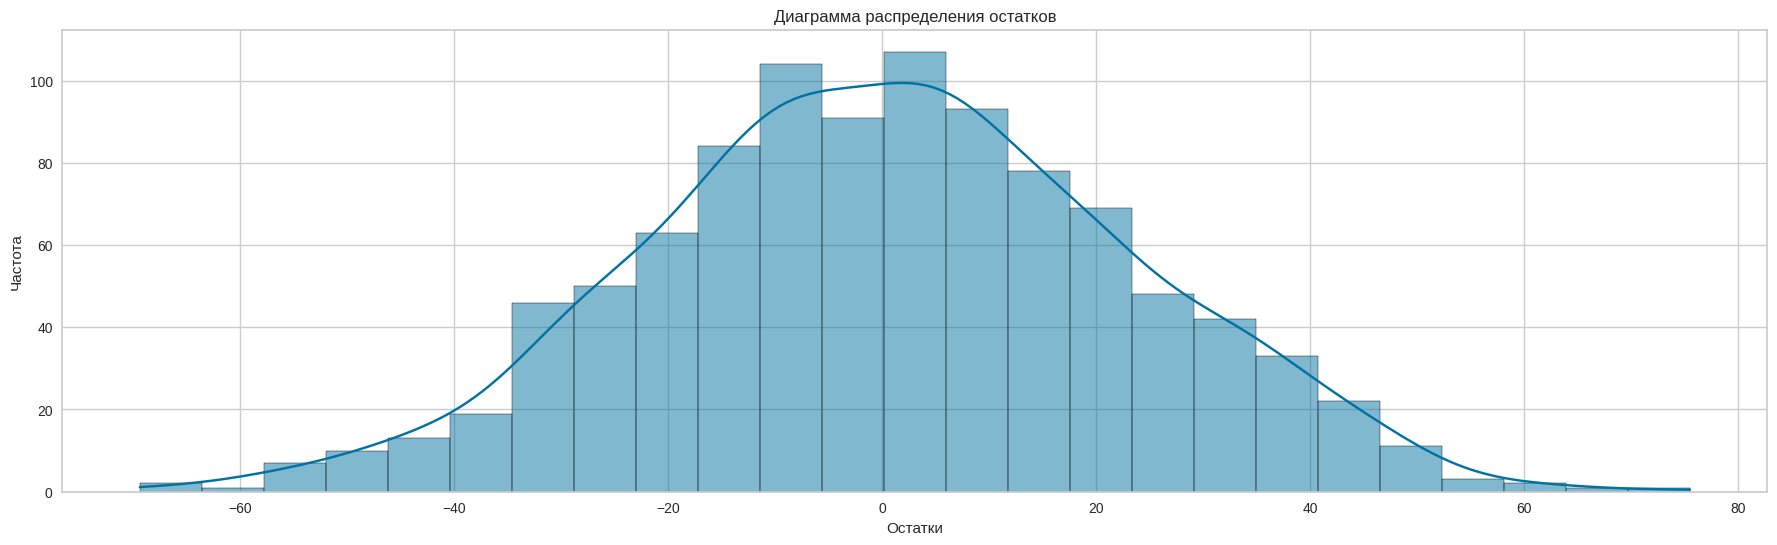


Ряд норманый
Статистика теста: 0.9988048076629639
p-значение: 0.7580053210258484


In [31]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Пример данных
data = np.random.normal(0, 22, 1000)
# data = np.random.exponential(1,1000)
# data = np.random.standard_normal(1000)
alpha = [1, 2, 3]

# Генерация случайных значений из распределения Дирихле
# data = np.random.lognormal(0,1,1000)
plt.figure(figsize=(22, 6))
sns.histplot(data, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Диаграмма распределения остатков')
plt.show()
print()

# Проведение теста Шапиро-Уилка
statistic, p_value = stats.shapiro(data)
if p_value >0.05:
    print('Ряд норманый')
else:
  print('Не норманый ряд')
# Вывод результатов теста
print("Статистика теста:", statistic)
print("p-значение:", p_value)

In [32]:
import pandas as pd

# Пример исходных данных
data = pd.DataFrame({
    'категория': ['A', 'B', 'A', 'C', 'B'],
    'целевая_переменная': [2, 0, 1, 2, 0]
})

# Вычисление среднего значения целевой переменной для каждой категории
mean_encoding = data.groupby('категория')['целевая_переменная'].mean().to_dict()
print(mean_encoding)

# Применение Target Encoding категорий
data['категория_код'] = data['категория'].map(mean_encoding)

print(data)

{'A': 1.5, 'B': 0.0, 'C': 2.0}
  категория  целевая_переменная  категория_код
0         A                   2            1.5
1         B                   0            0.0
2         A                   1            1.5
3         C                   2            2.0
4         B                   0            0.0


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Создаем случайные данные с 4 предикторами
np.random.seed(42)
X = np.random.rand(100, 4)
y = np.dot(X, np.array([1, 2, 3, 4])) + np.random.normal(0, 0.1, 100)

# Добавляем столбец с единицами для константы в модели
X = sm.add_constant(X)

# Строим модель линейной регрессии
model = sm.OLS(y, X).fit()

# Получаем предсказанные значения
y_pred = model.predict(X)

# Получаем остатки
residuals = y - y_pred

# Выводим матрицу предикторов и остатки
predictor_matrix = pd.DataFrame(X, columns=['const', 'pred1', 'pred2', 'pred3', 'pred4'])
print("Матрица предикторов:")
print(predictor_matrix.head())

residuals_df = pd.DataFrame({'residuals': residuals})
print("\nОстатки:")
print(residuals_df.head())

Матрица предикторов:
   const     pred1     pred2     pred3     pred4
0    1.0  0.374540  0.950714  0.731994  0.598658
1    1.0  0.156019  0.155995  0.058084  0.866176
2    1.0  0.601115  0.708073  0.020584  0.969910
3    1.0  0.832443  0.212339  0.181825  0.183405
4    1.0  0.304242  0.524756  0.431945  0.291229

Остатки:
   residuals
0   0.159231
1   0.008599
2   0.091693
3  -0.069386
4   0.035246


In [34]:
import numpy as np

# Создание фиктивных переменных для сезонных данных с использованием синусов и косинусов
def create_seasonal_features(n_obs, period, n_features=2):
    X = np.zeros((n_obs, 2*n_features))
    for i in range(1, n_features+1):
        X[:, 2*i-2] = np.sin(2*np.pi*i*np.arange(n_obs)/period)  # синусоиды
        X[:, 2*i-1] = np.cos(2*np.pi*i*np.arange(n_obs)/period)  # косинусоиды
    return X

# Пример создания фиктивных переменных для сезонных данных с периодом 12 (год)
n_obs = 100
period = 12
n_features = 2
seasonal_features = create_seasonal_features(n_obs, period, n_features)
print(seasonal_features)

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 5.00000000e-01  8.66025404e-01  8.66025404e-01  5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01  8.66025404e-01 -5.00000000e-01]
 [ 1.00000000e+00  6.12323400e-17  1.22464680e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01 -8.66025404e-01 -5.00000000e-01]
 [ 5.00000000e-01 -8.66025404e-01 -8.66025404e-01  5.00000000e-01]
 [ 1.22464680e-16 -1.00000000e+00 -2.44929360e-16  1.00000000e+00]
 [-5.00000000e-01 -8.66025404e-01  8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01  8.66025404e-01 -5.00000000e-01]
 [-1.00000000e+00 -1.83697020e-16  3.67394040e-16 -1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01 -8.66025404e-01 -5.00000000e-01]
 [-5.00000000e-01  8.66025404e-01 -8.66025404e-01  5.00000000e-01]
 [-2.44929360e-16  1.00000000e+00 -4.89858720e-16  1.00000000e+00]
 [ 5.00000000e-01  8.66025404e-01  8.66025404e-01  5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01  8.66025404e-01 -5.00000000e

In [35]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 621.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 3.4 MB/s eta 0:00:00


In [36]:
from tsfresh.feature_extraction import extract_features
import pandas as pd

# Загрузка временного ряда в формате DataFrame
data = pd.DataFrame({
    'id': range(0,98),
    'time': pd.date_range(start='1/1/2021', periods=98, freq='D'),
    'value': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
              60, 65, 70, 75, 80, 85, 90, 95, 100, 105,
              110, 115, 120, 125, 130, 135, 140, 145, 150,
              155, 160, 165, 170, 175, 180, 185, 190, 195,
              200, 205, 210, 215, 220, 225, 230, 235, 240,
              245, 250, 255, 260, 265, 270, 275, 280, 285,
              290, 295, 300, 305, 310, 315, 320, 325, 330,
              335, 340, 345, 350, 355, 360, 365, 370, 375,
              380, 385, 390, 395, 400, 405, 410, 415, 420,
              425, 430, 435, 440, 445, 450, 455, 460, 465,
              470, 475, 480, 485, 490, 495]  # Пример значений временного ряда
})

# Извлечение признаков с помощью tsfreshd
print(data)

extracted_features = extract_features(data, column_id='id', column_sort='time',column_value='value')

print(extracted_features)

    id       time  value
0    0 2021-01-01     10
1    1 2021-01-02     15
2    2 2021-01-03     20
3    3 2021-01-04     25
4    4 2021-01-05     30
..  ..        ...    ...
93  93 2021-04-04    475
94  94 2021-04-05    480
95  95 2021-04-06    485
96  96 2021-04-07    490
97  97 2021-04-08    495

[98 rows x 3 columns]


Feature Extraction: 100%|██████████| 98/98 [00:05<00:00, 16.63it/s]


    value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                              0.0                       0.0   
1                                              0.0                       0.0   
2                                              0.0                       0.0   
3                                              0.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
93                                             0.0                       0.0   
94                                             0.0                       0.0   
95                                             0.0                       0.0   
96                                             0.0                       0.0   
97                                             0.0                       0.0   

    value__has_duplicate_min  value__ha

In [37]:
pd.date_range(start='1/1/2021', periods=10, freq='D')

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10'],
              dtype='datetime64[ns]', freq='D')

In [38]:
len([10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
              60, 65, 70, 75, 80, 85, 90, 95, 100, 105,
              110, 115, 120, 125, 130, 135, 140, 145, 150,
              155, 160, 165, 170, 175, 180, 185, 190, 195,
              200, 205, 210, 215, 220, 225, 230, 235, 240,
              245, 250, 255, 260, 265, 270, 275, 280, 285,
              290, 295, 300, 305, 310, 315, 320, 325, 330,
              335, 340, 345, 350, 355, 360, 365, 370, 375,
              380, 385, 390, 395, 400, 405, 410, 415, 420,
              425, 430, 435, 440, 445, 450, 455, 460, 465,
              470, 475, 480, 485, 490, 495])

98

In [39]:
from tsfresh.feature_extraction import extract_features
import pandas as pd

# Создание примера DataFrame с временными рядами
data = pd.DataFrame({
    'id': [1, 1, 1, 2, 2, 2],
    'time': pd.to_datetime(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-01', '2021-01-02', '2021-01-03']),
    'value': [10, 15, 20, 5, 10, 15]
})

# Извлечение признаков из временных рядов
extracted_features = extract_features(data, column_id='id', column_sort='time', column_value='value')

print(extracted_features)

Feature Extraction: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   0.0               45.0   
2                       0.0                   0.0               30.0   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1              725.0                     5.0                 5.0   
2              350.0                     5.0                 5.0   

   value__mean_second_derivative_central  value__median  ...  \
1                                    0.0           15.0  ...   
2                                    0.0           10.0  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.693147                         0.693147   
2      

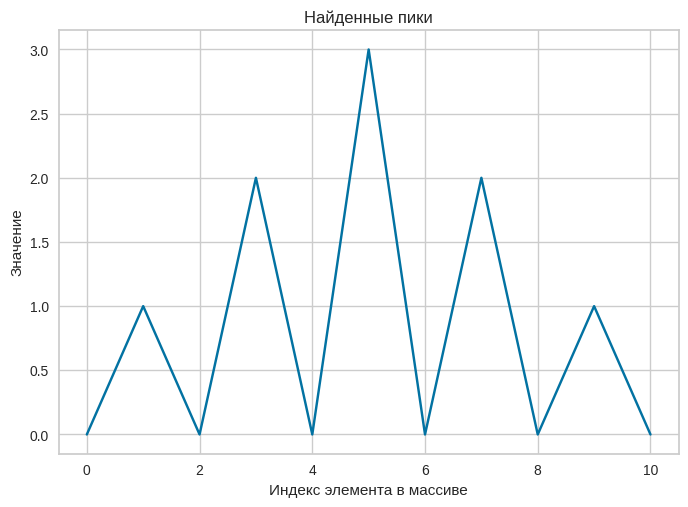

Индексы пиков: [1 3 5 7 9]


In [40]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Создание примера одномерного массива с пиками
data = np.array([0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0])
# data = np.array([0, 1, 2, 3, 4, 5, 22, 7, 8, 9, 10])

# Нахождение пиков в массиве
peaks, _ = find_peaks(data)

# Визуализация данных и пиков
plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.xlabel('Индекс элемента в массиве')
plt.ylabel('Значение')
plt.title('Найденные пики')
plt.show()

print("Индексы пиков:", peaks)

In [41]:
!pip install tsfresh

In [42]:
from tsfresh.feature_extraction import extract_features
import pandas as pd

# Предположим, у вас есть DataFrame data с временными рядами, где каждая строка - отдельное наблюдение
# Необходимо указать столбец 'id', который идентифицирует временные ряды, и столбец 'value' с данными временного ряда

# Создание примера DataFrame с временными рядами
data = pd.DataFrame({
    'id': [1, 1, 1, 2, 2, 2],
    'time': pd.to_datetime(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-01', '2021-01-02', '2021-01-03']),
    'value': [10, 15, 20, 5, 10, 15]
})

# Извлечение признаков из временных рядов
extracted_features = extract_features(data, column_id='id', column_sort='time', column_value='value')

print(extracted_features)

Feature Extraction: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   0.0               45.0   
2                       0.0                   0.0               30.0   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1              725.0                     5.0                 5.0   
2              350.0                     5.0                 5.0   

   value__mean_second_derivative_central  value__median  ...  \
1                                    0.0           15.0  ...   
2                                    0.0           10.0  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.693147                         0.693147   
2      

In [43]:
for i in extracted_features.columns:
    print(i)

value__variance_larger_than_standard_deviation
value__has_duplicate_max
value__has_duplicate_min
value__has_duplicate
value__sum_values
value__abs_energy
value__mean_abs_change
value__mean_change
value__mean_second_derivative_central
value__median
value__mean
value__length
value__standard_deviation
value__variation_coefficient
value__variance
value__skewness
value__kurtosis
value__root_mean_square
value__absolute_sum_of_changes
value__longest_strike_below_mean
value__longest_strike_above_mean
value__count_above_mean
value__count_below_mean
value__last_location_of_maximum
value__first_location_of_maximum
value__last_location_of_minimum
value__first_location_of_minimum
value__percentage_of_reoccurring_values_to_all_values
value__percentage_of_reoccurring_datapoints_to_all_datapoints
value__sum_of_reoccurring_values
value__sum_of_reoccurring_data_points
value__ratio_value_number_to_time_series_length
value__sample_entropy
value__maximum
value__absolute_maximum
value__minimum
value__benfor

In [44]:
extracted_features['value__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"']

1   NaN
2   NaN
Name: value__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", dtype: float64

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


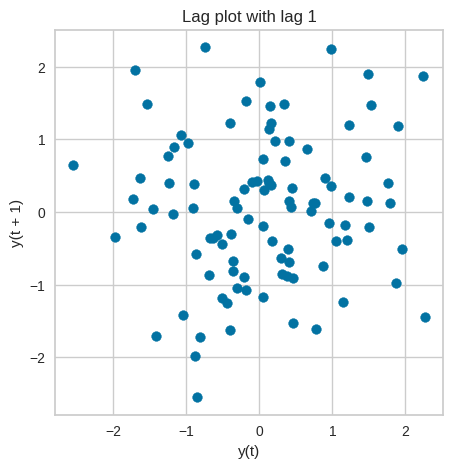

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Создание примера временного ряда
np.random.seed(0)
n = 100
df = pd.DataFrame({'y': np.random.randn(n)})

# Построение lag plot с отставанием на 1 шаг
fig, ax = plt.subplots(figsize=[5, 5])
ax = pd.plotting.lag_plot(df["y"], lag=1, ax=ax)
ax.set_title("Lag plot with lag 1")
plt.show()

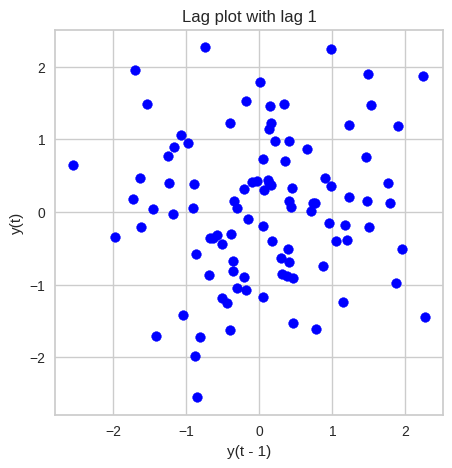

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Создание примера временного ряда
np.random.seed(0)
n = 100
df = pd.DataFrame({'y': np.random.randn(n)})

# Построение lag plot с отставанием на 1 шаг
lag = 1
plt.figure(figsize=(5, 5))
plt.scatter(df["y"][:-lag], df["y"][lag:], color='blue')
plt.title(f"Lag plot with lag {lag}")
plt.xlabel(f'y(t - {lag})')
plt.ylabel('y(t)')
plt.show()

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
%%time
import pandas as pd
import numpy as np
chunksize = 1_000_000_0  # Размер порции данных
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/zvezda/MIO_1/Corporación Favorita Grocery Sales Forecasting/train.csv',chunksize=chunksize,low_memory=False)

# Ленивая фильтрация и группировка
filtered_grouped_data = pd.DataFrame()
io = 0
# Итерация по каждой порции данных

filters = []

ii = 0
for chunk in train:
    # if ii == 0:
    #     # for i in range(1, 2):
    #     #     filter_condition = (chunk['store_nbr'] == i) & (chunk['item_nbr'] == 314384)
    #     #     filters.append(filter_condition)
    #     # for i in range(1, 3):
    #     #     filter_condition = f"(chunk['store_nbr'] == {i}) & (chunk['item_nbr'] == 314384)"
    #     #     filters.append(filter_condition)
    #     # filter_string = ' | '.join(filters)


    #     # grouped_data = chunk.eval(filter_string)
    #     # print(grouped_data)
    #     print('____')

    # Ленивая фильтрация
    # filtered_data = chunk[chunk['column'] > 100]  # Пример фильтрации по значению столбца

    # # Ленивая группировка
    # grouped_data = filtered_data.groupby('column2').sum()  # Пример группировки и суммирования
    # 502331

    grouped_data = chunk[(chunk['store_nbr'] == 1) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 2) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 3) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 4) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 5) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 6) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 7) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 8) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 9) & (chunk['item_nbr'] == 314384) |
                          (chunk['store_nbr'] == 10) & (chunk['item_nbr'] == 314384)
                         ]
    # grouped_data = chunk[np.any(filters, axis=0)]


    infores = chunk['item_nbr'].value_counts().sort_values(ascending=False)[:5]
    # print(infores)

    # Добавление результатов операций в общий DataFrame
    filtered_grouped_data = pd.concat([filtered_grouped_data, grouped_data])
    io+=1
    ii+=1

# # Вывод результата
# print(filtered_grouped_data)
# print(io)

CPU times: user 1min 21s, sys: 36 s, total: 1min 57s
Wall time: 2min 30s


In [49]:
import numpy as np
import random
import seaborn as sns
def func_model(data, SKU):
    import matplotlib.pyplot as plt

    random.seed(1)
    np.random.seed(1)

    end_train = '2016-06-01 23:59:59'
    end_valid = '2017-01-01 23:59:59'




    # Добавление прогноза на график
    plt.figure(figsize=(22, 6))
    plt.plot(data.index[data.index<=end_train], data[:end_train], label='Тренеровачные данные')
    plt.plot(data.index[(data.index <= end_valid) & (data.index >= end_train)], data[end_train:end_valid],label='Valid данные')
    plt.plot(data.index[data.index >= end_valid], data[end_valid:],label='Test данные')
    # Добавление точки на график
    # plt.plot(random_date, data.loc[random_date], 'ro')  # 'ro' означает красные круглые маркеры
    # plt.plot(random_date, data.loc[random_date]/1.5, 'yo')  # 'ro' означает красные круглые маркеры

    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.title(f'График временного ряда с прогнозом forecaster SKU: {SKU}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(data)

    with sns.plotting_context("paper"):
        fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[15, 10])
        for i, ax_ in enumerate(ax.flatten()):
            pd.plotting.lag_plot(data, lag=i + 1, ax=ax_)

            ax_.set_title(f"Lag {i+1}")
            ax_.ticklabel_format(style="sci", scilimits=(0, 0))
        plt.tight_layout()

    # vv = pd.plotting.lag_plot(data, lag=1)
    # print(vv)


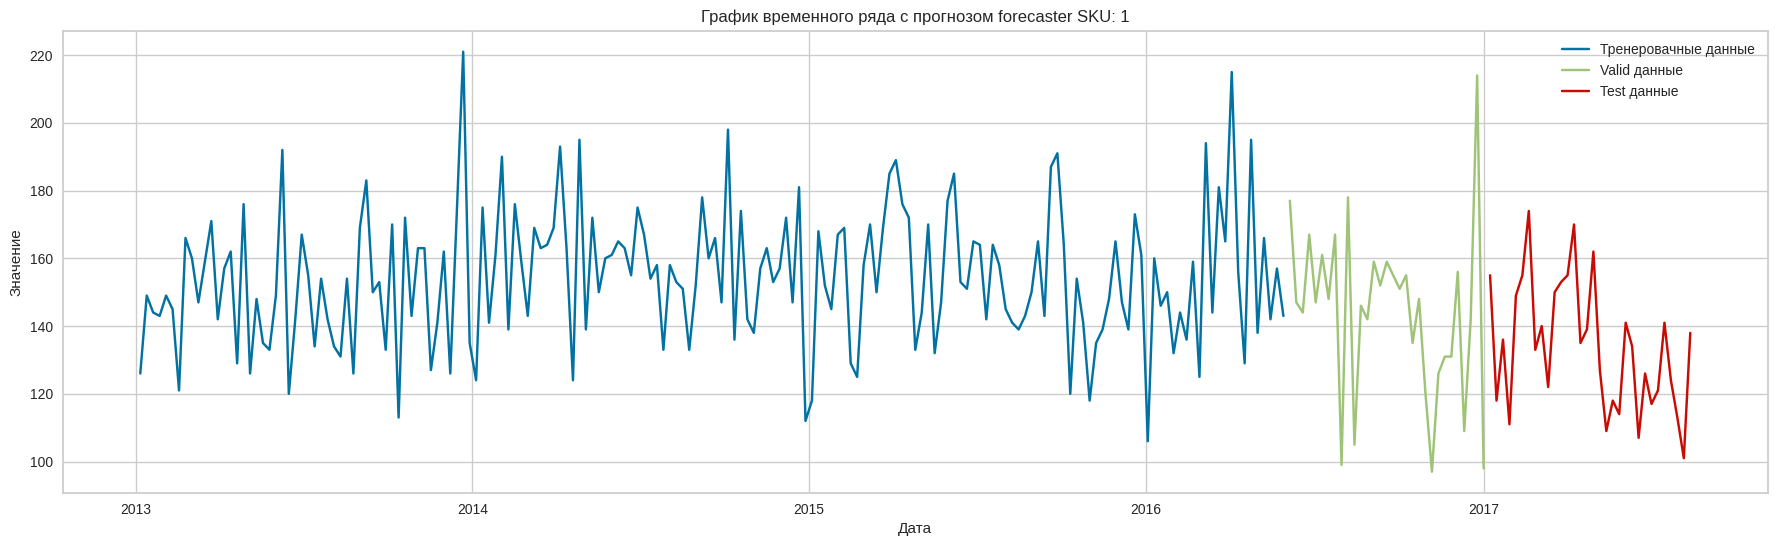

            unit_sales
date                  
2013-01-06       126.0
2013-01-13       149.0
2013-01-20       144.0
2013-01-27       143.0
2013-02-03       149.0
...                ...
2017-07-16       141.0
2017-07-23       124.0
2017-07-30       113.0
2017-08-06       101.0
2017-08-13       138.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


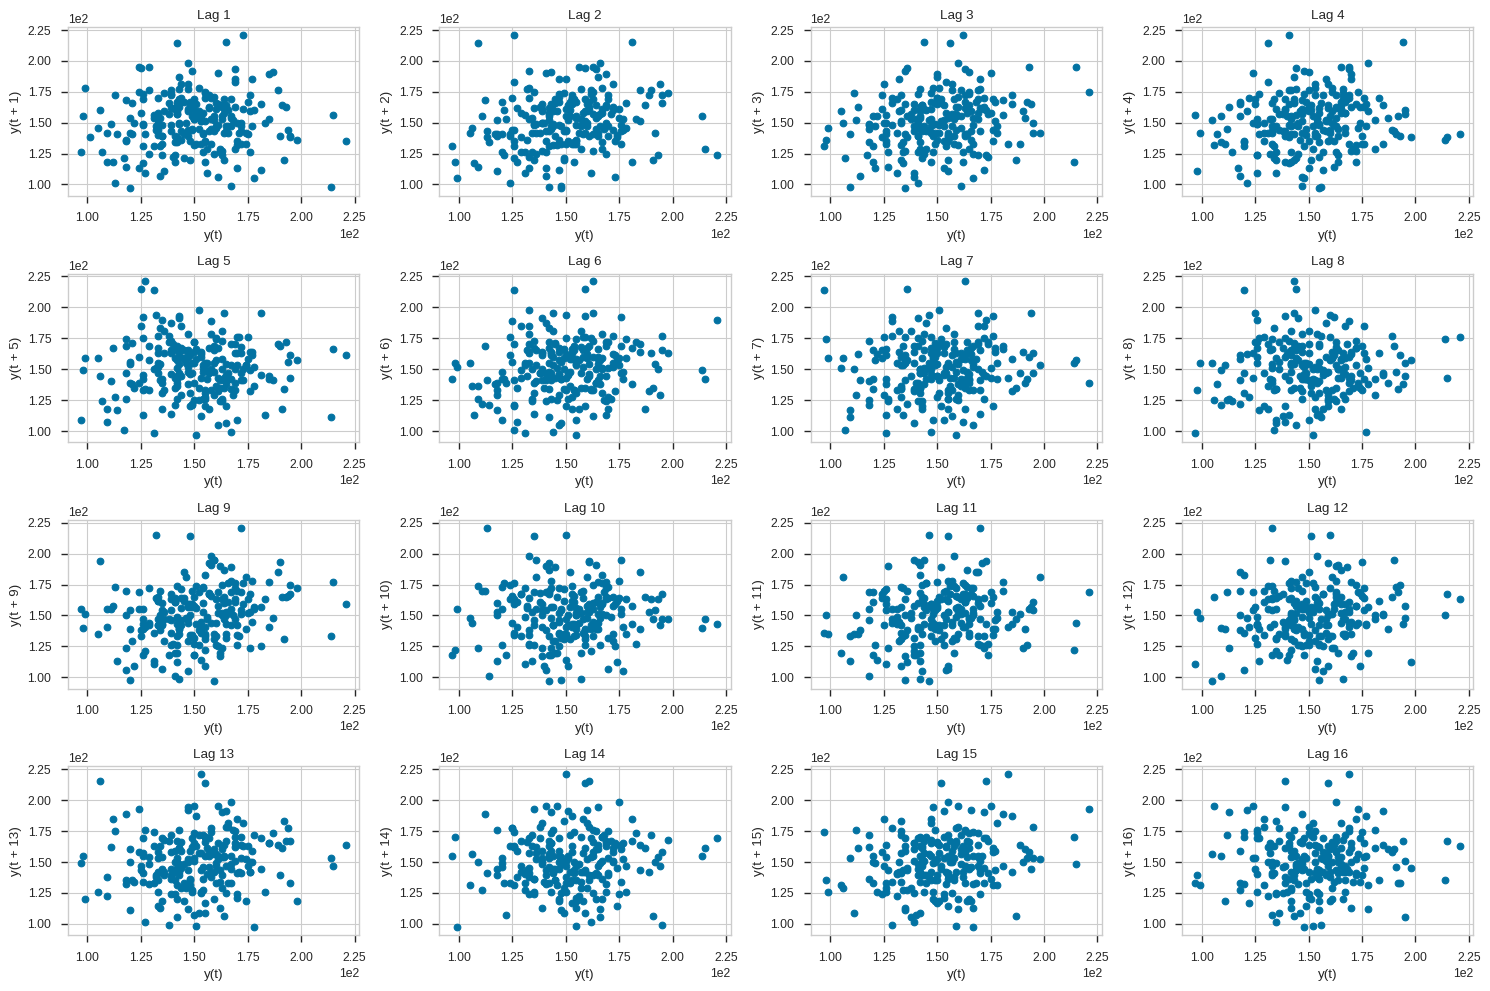

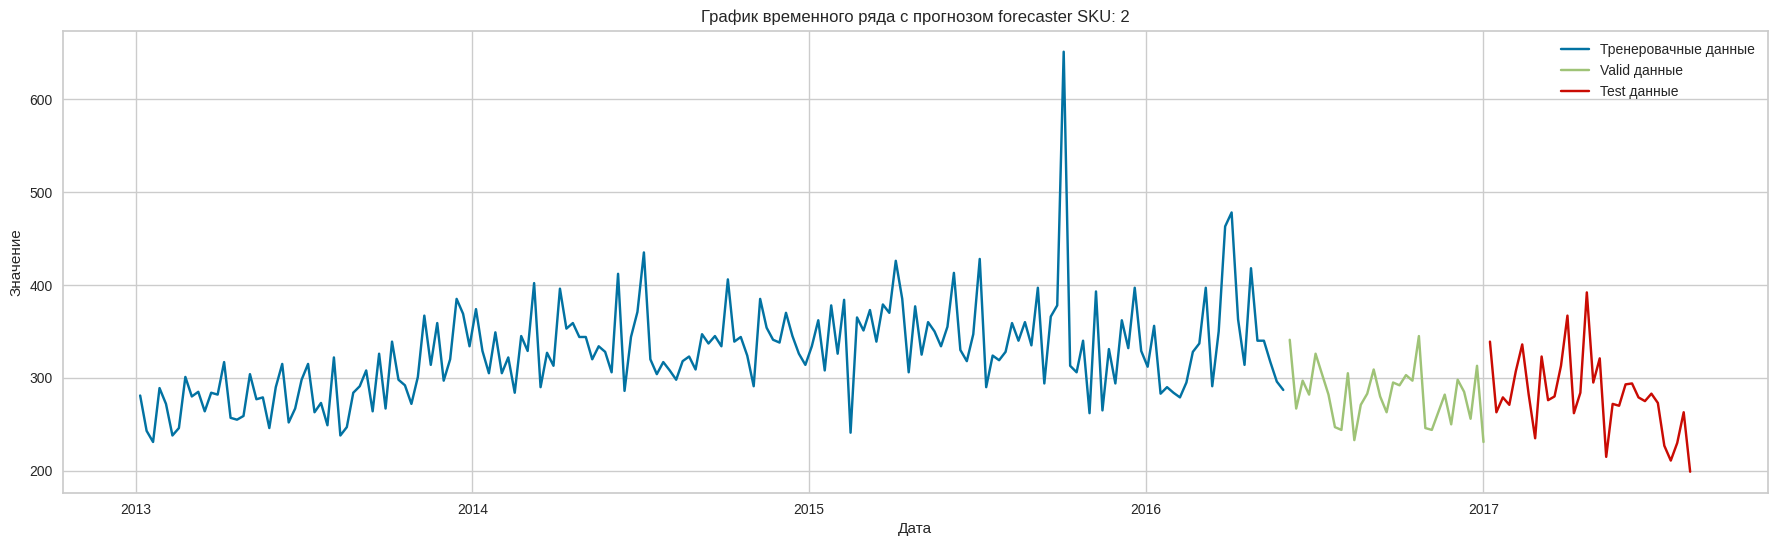

            unit_sales
date                  
2013-01-06       281.0
2013-01-13       243.0
2013-01-20       231.0
2013-01-27       289.0
2013-02-03       272.0
...                ...
2017-07-16       227.0
2017-07-23       211.0
2017-07-30       230.0
2017-08-06       263.0
2017-08-13       199.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


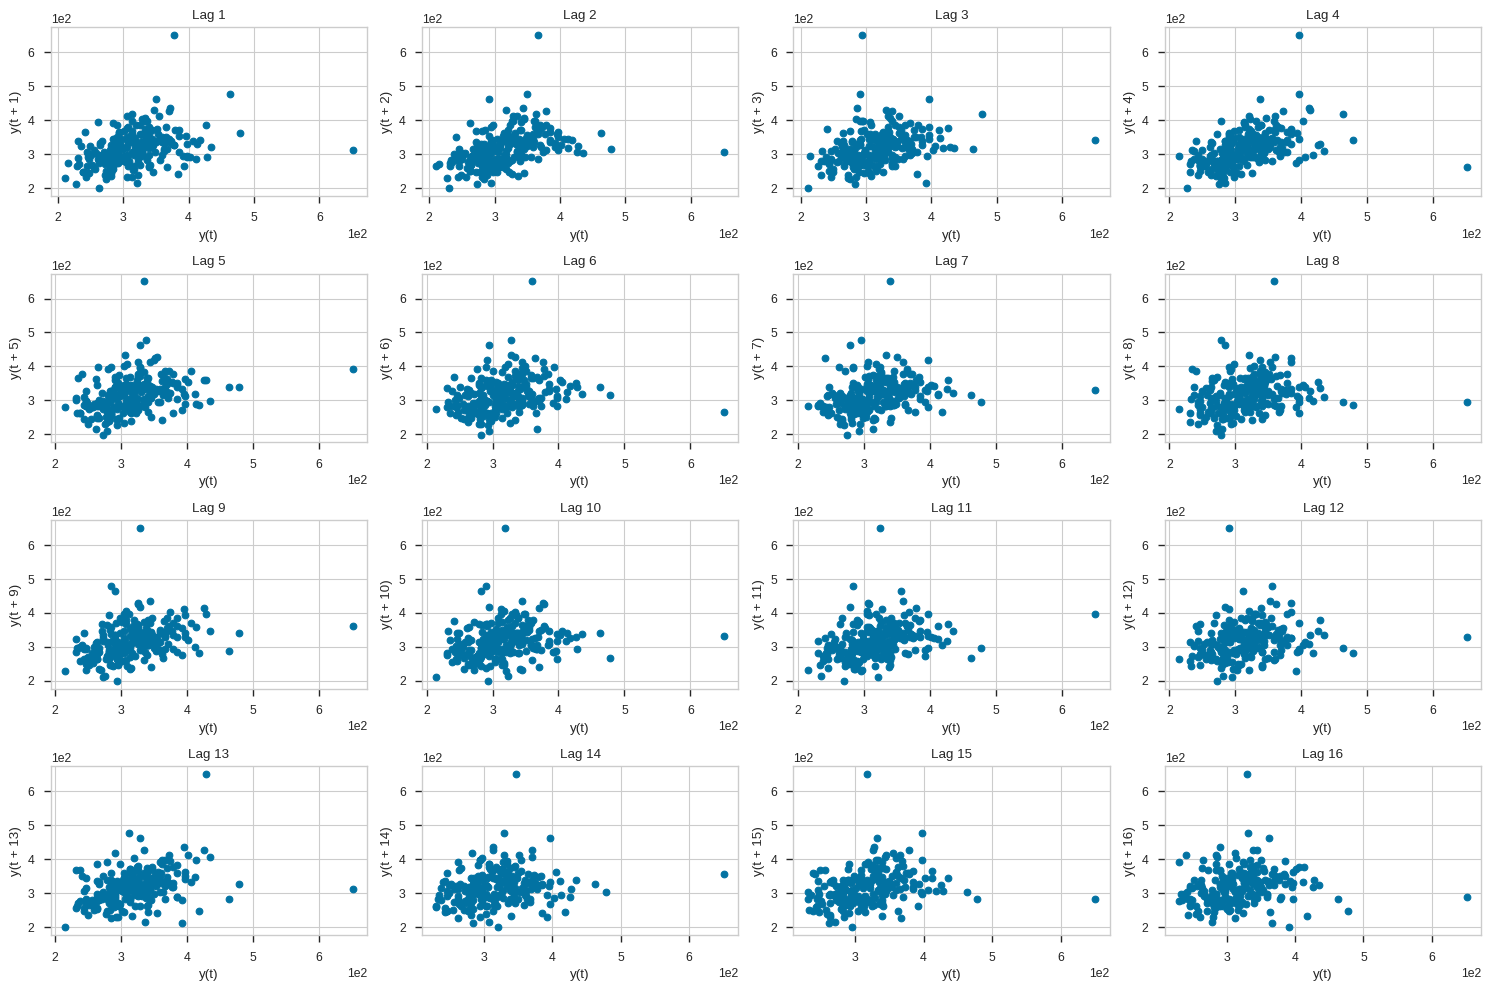

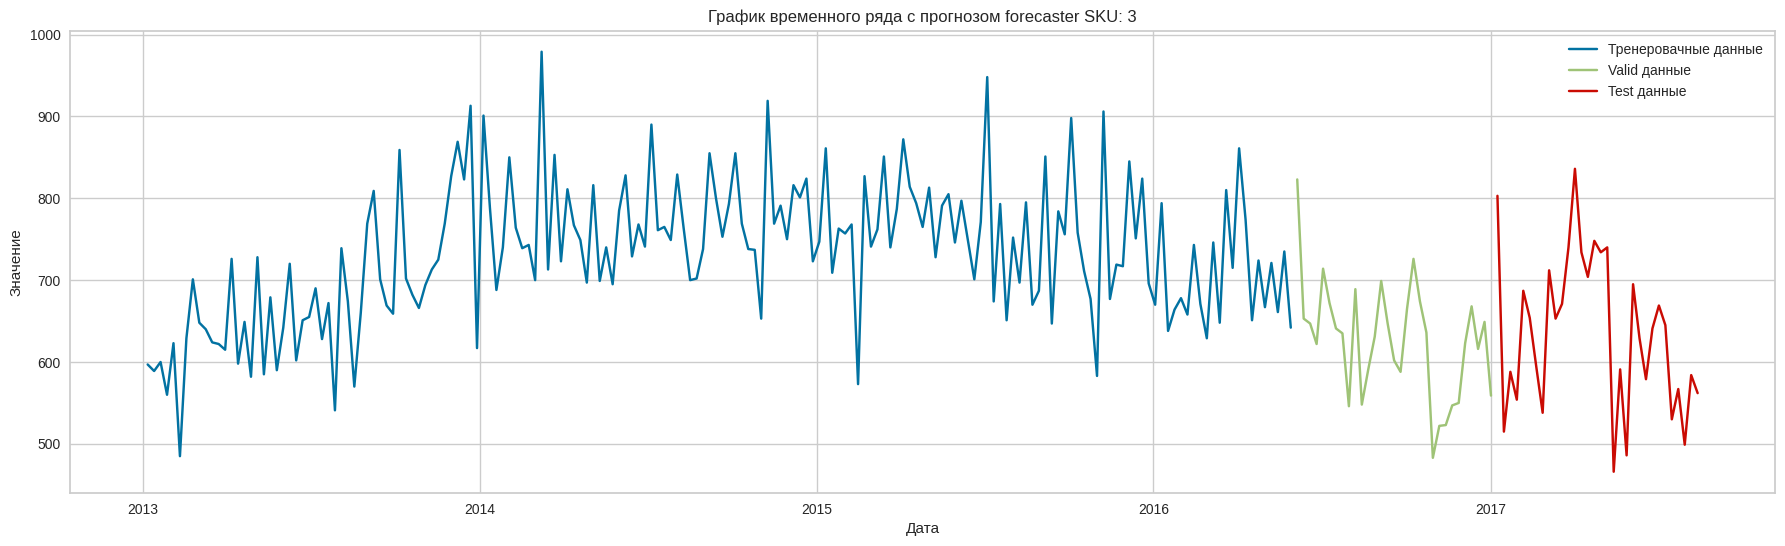

            unit_sales
date                  
2013-01-06       597.0
2013-01-13       589.0
2013-01-20       600.0
2013-01-27       560.0
2013-02-03       623.0
...                ...
2017-07-16       530.0
2017-07-23       567.0
2017-07-30       499.0
2017-08-06       584.0
2017-08-13       562.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


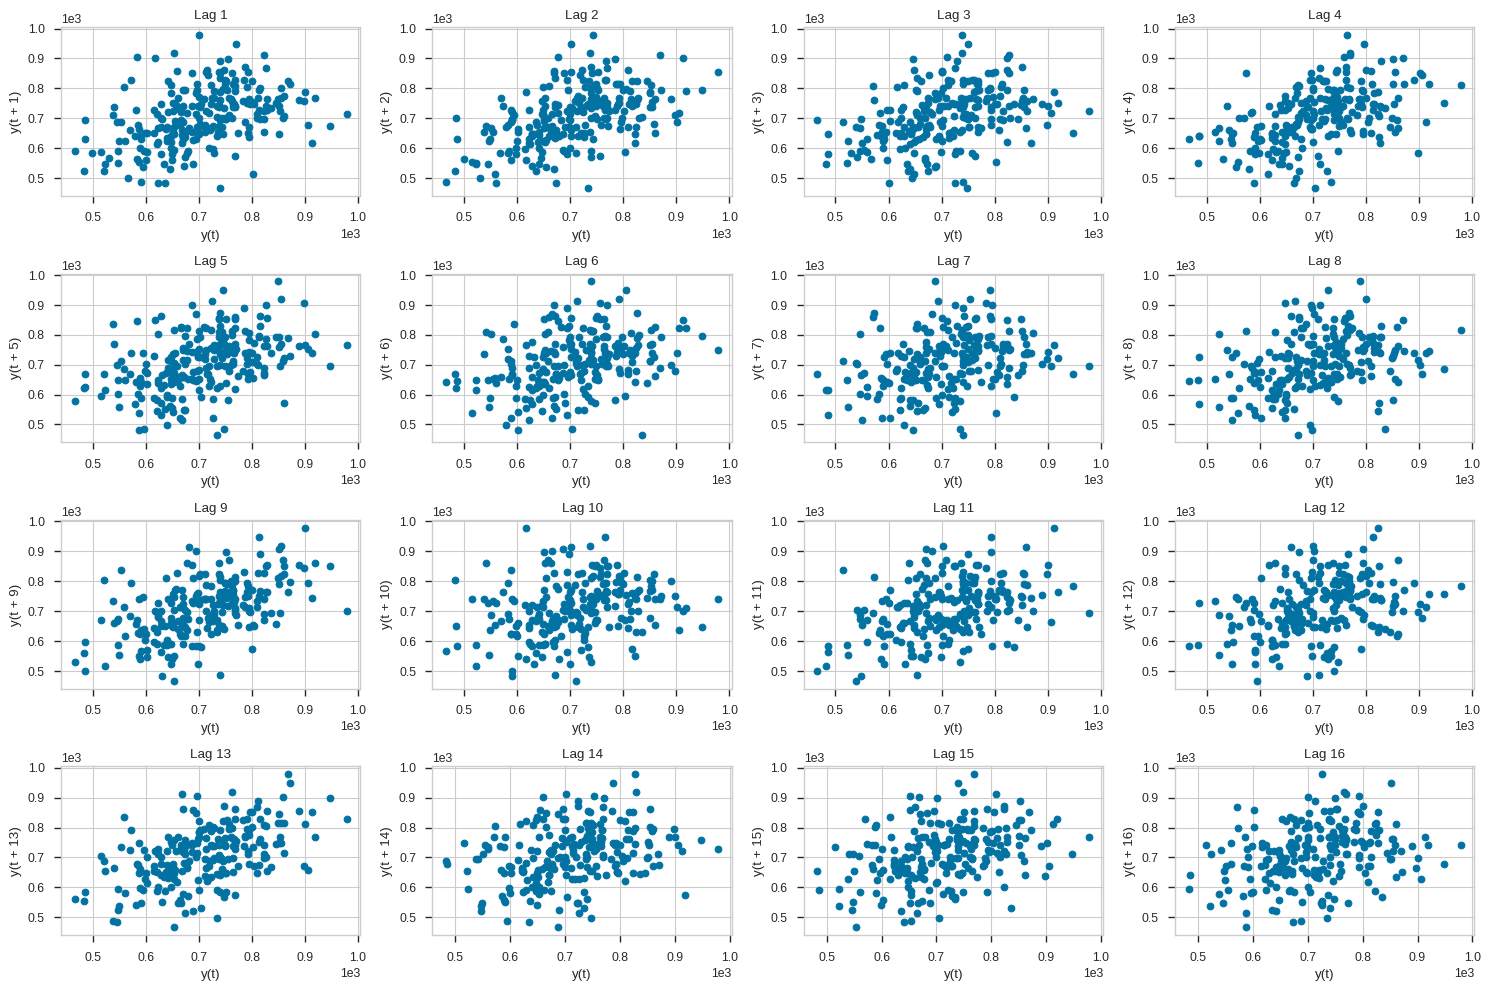

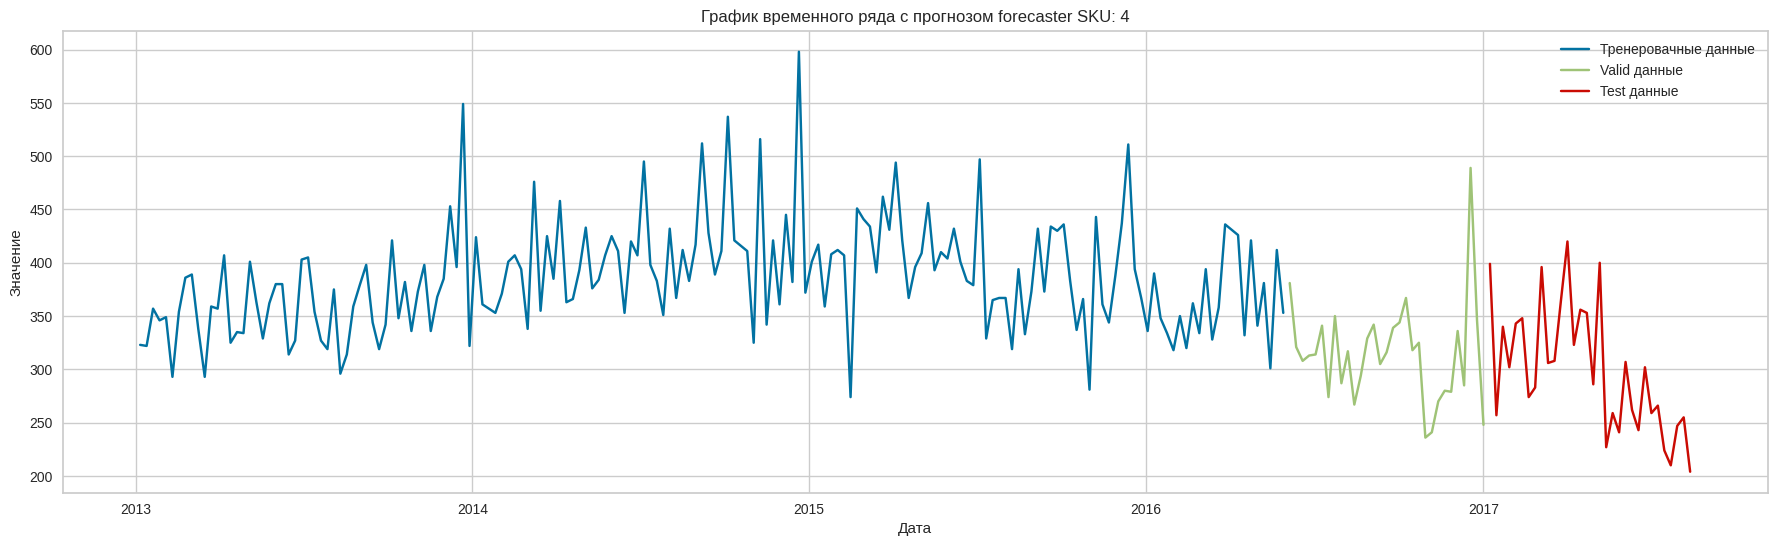

            unit_sales
date                  
2013-01-06       323.0
2013-01-13       322.0
2013-01-20       357.0
2013-01-27       346.0
2013-02-03       349.0
...                ...
2017-07-16       224.0
2017-07-23       210.0
2017-07-30       247.0
2017-08-06       255.0
2017-08-13       204.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


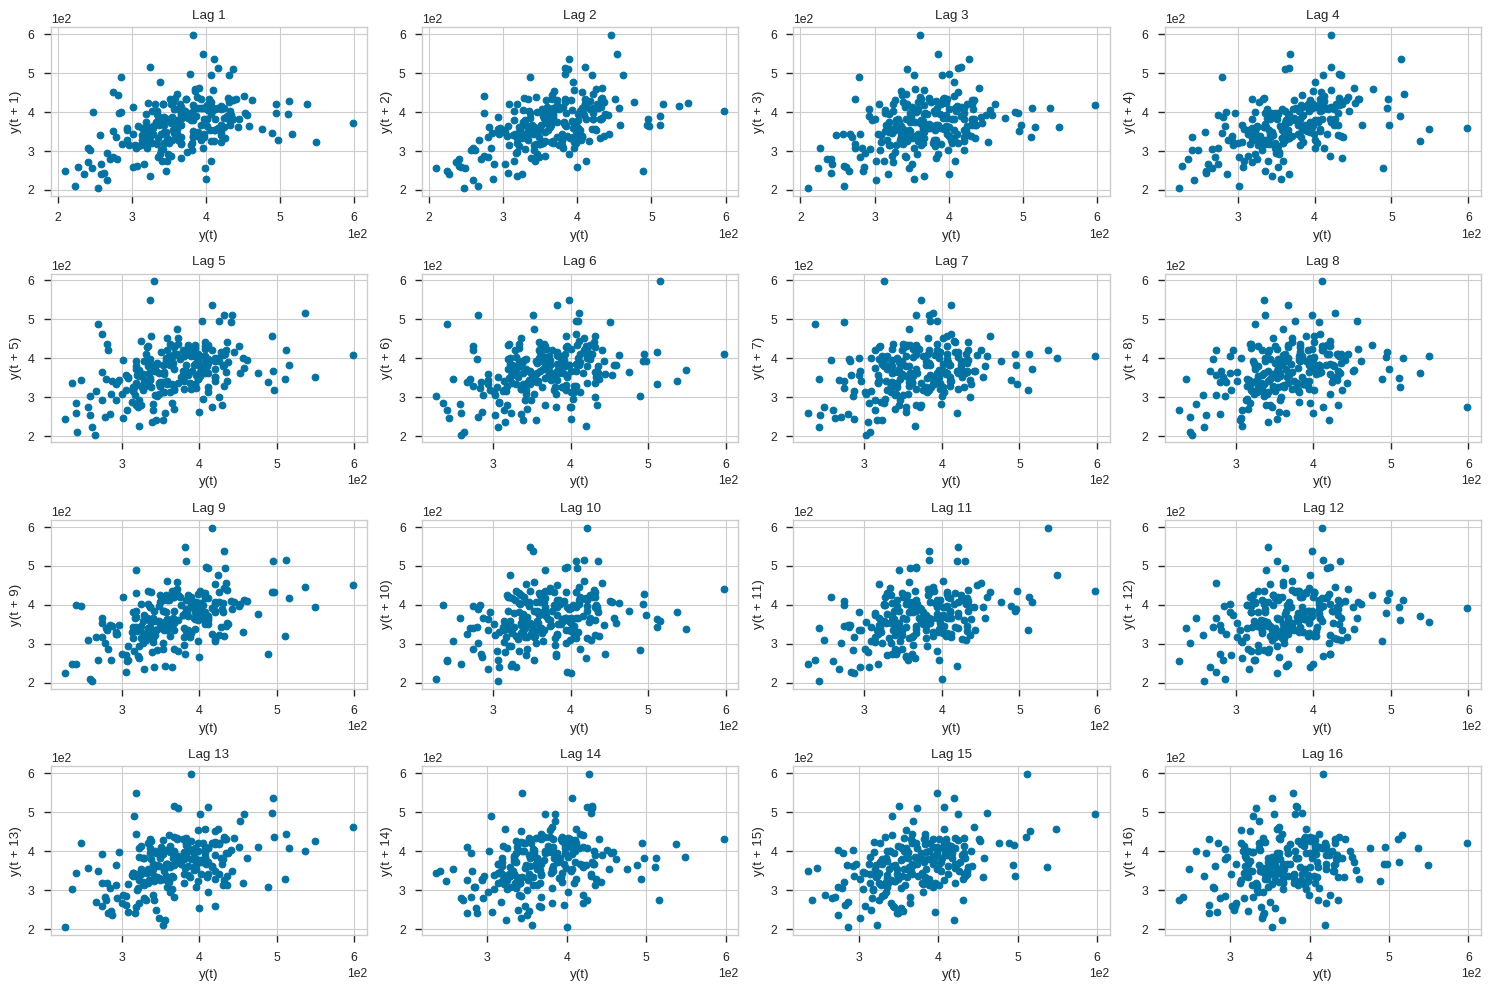

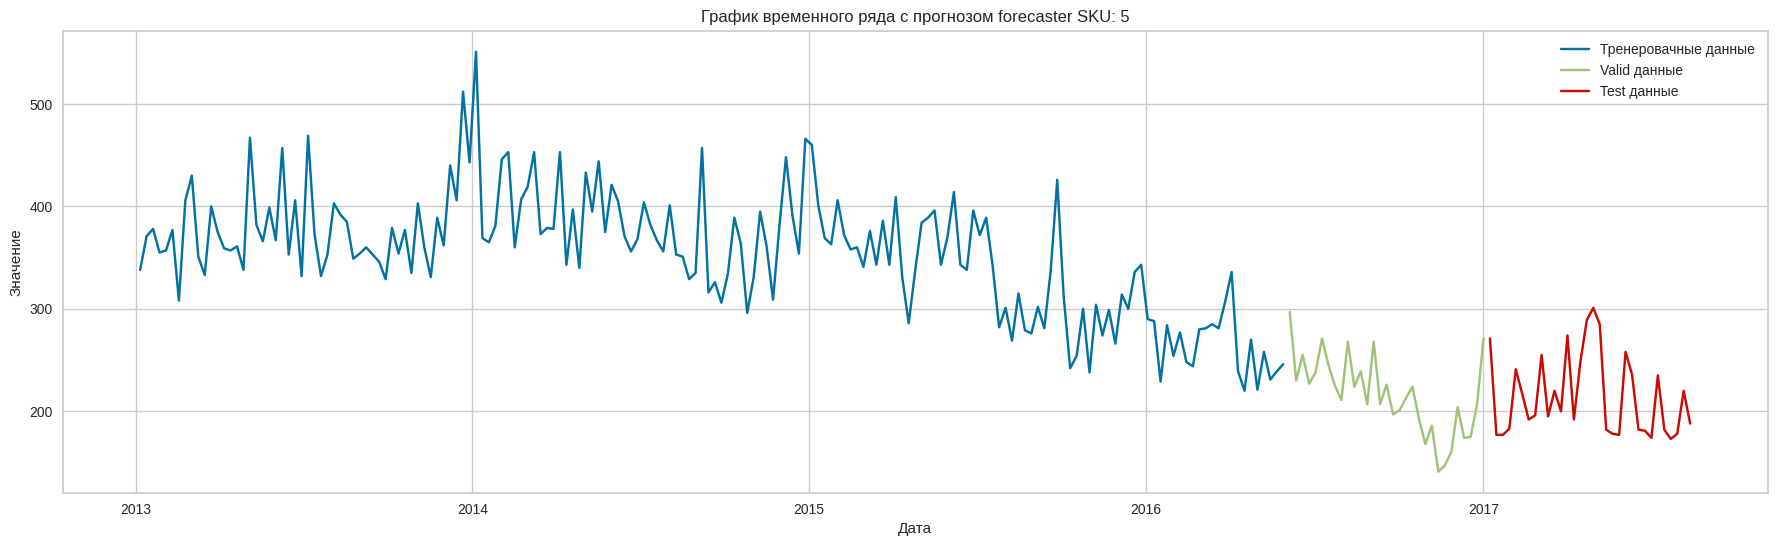

            unit_sales
date                  
2013-01-06       338.0
2013-01-13       371.0
2013-01-20       378.0
2013-01-27       355.0
2013-02-03       357.0
...                ...
2017-07-16       182.0
2017-07-23       173.0
2017-07-30       178.0
2017-08-06       220.0
2017-08-13       188.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


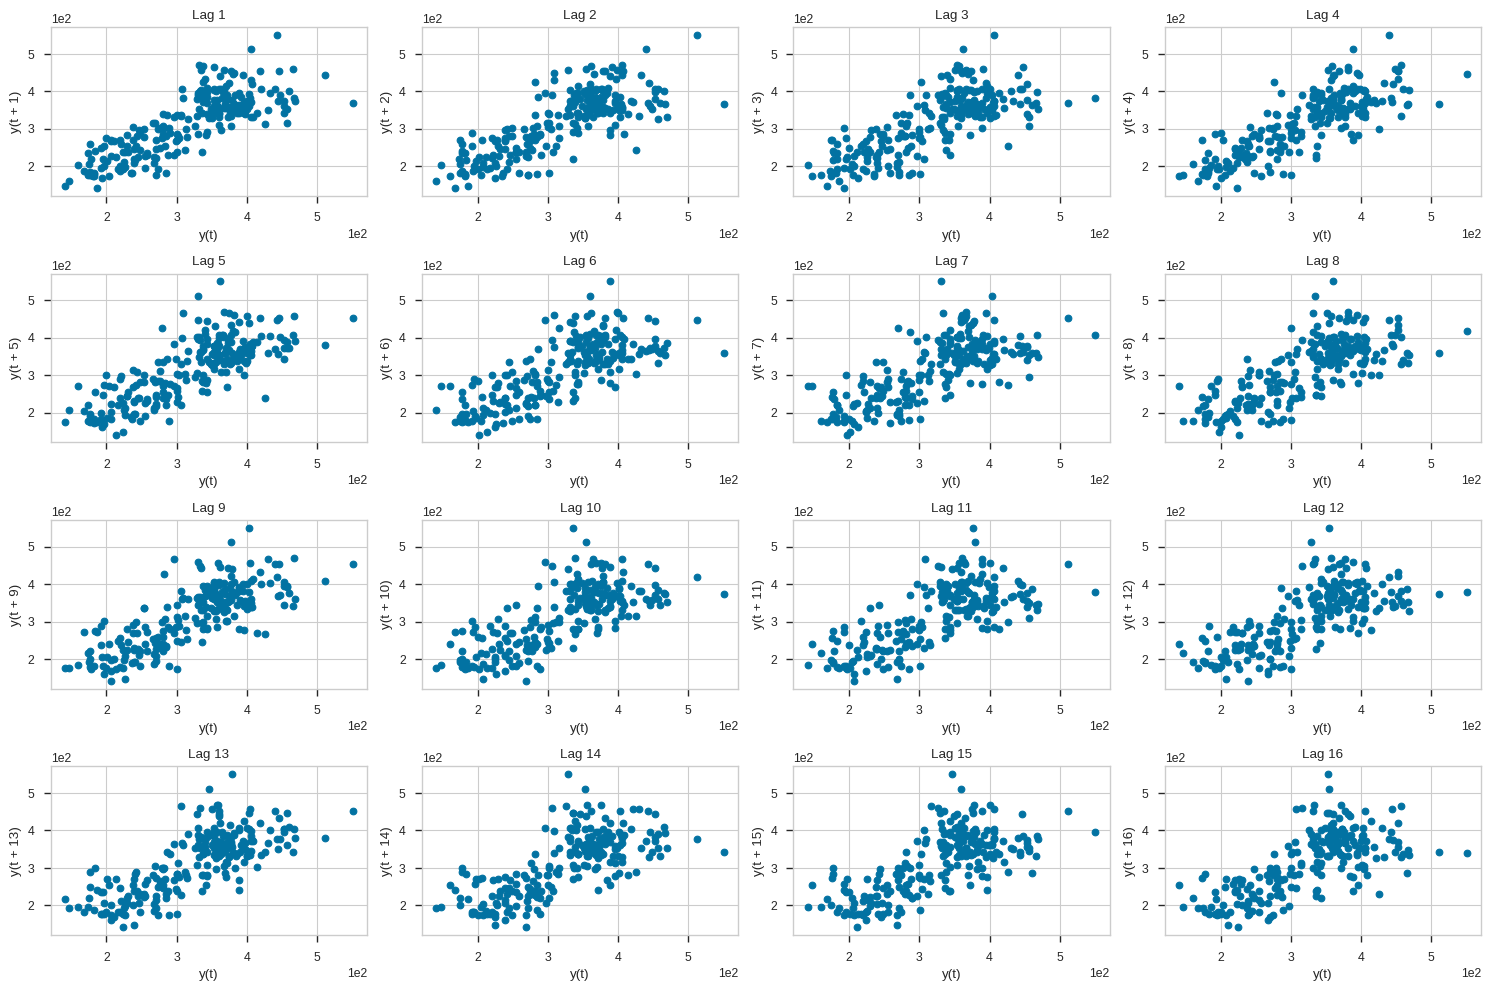

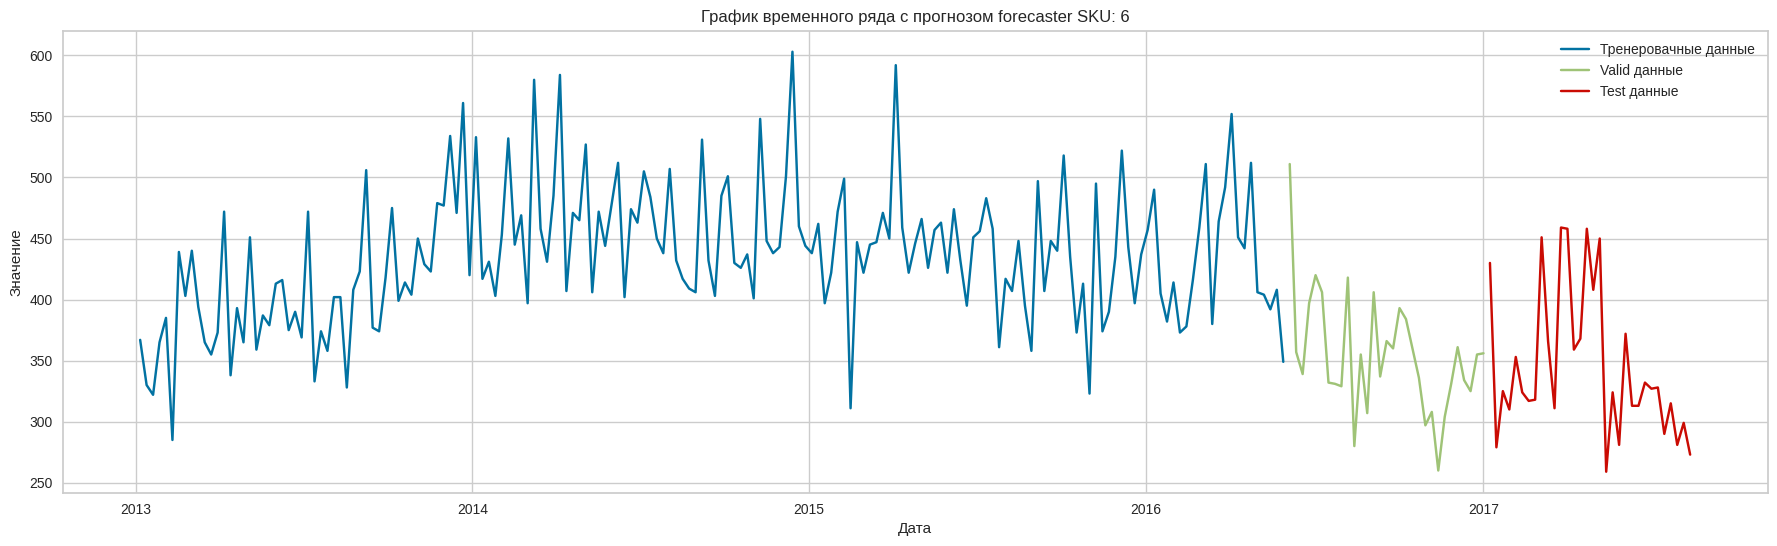

            unit_sales
date                  
2013-01-06       367.0
2013-01-13       330.0
2013-01-20       322.0
2013-01-27       365.0
2013-02-03       385.0
...                ...
2017-07-16       290.0
2017-07-23       315.0
2017-07-30       281.0
2017-08-06       299.0
2017-08-13       273.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


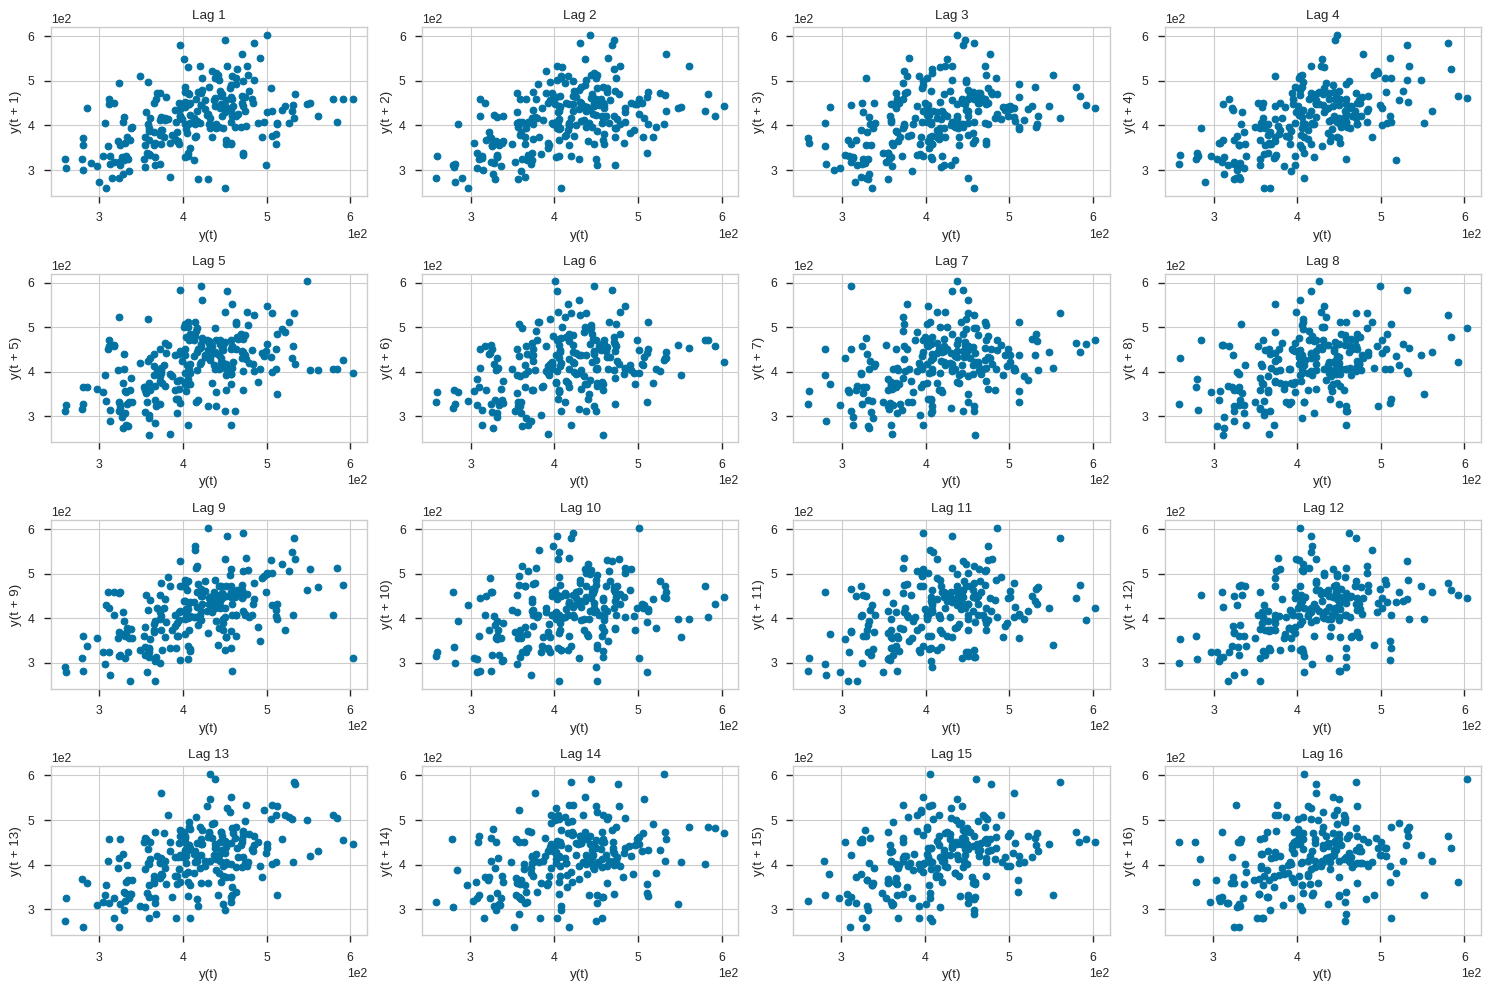

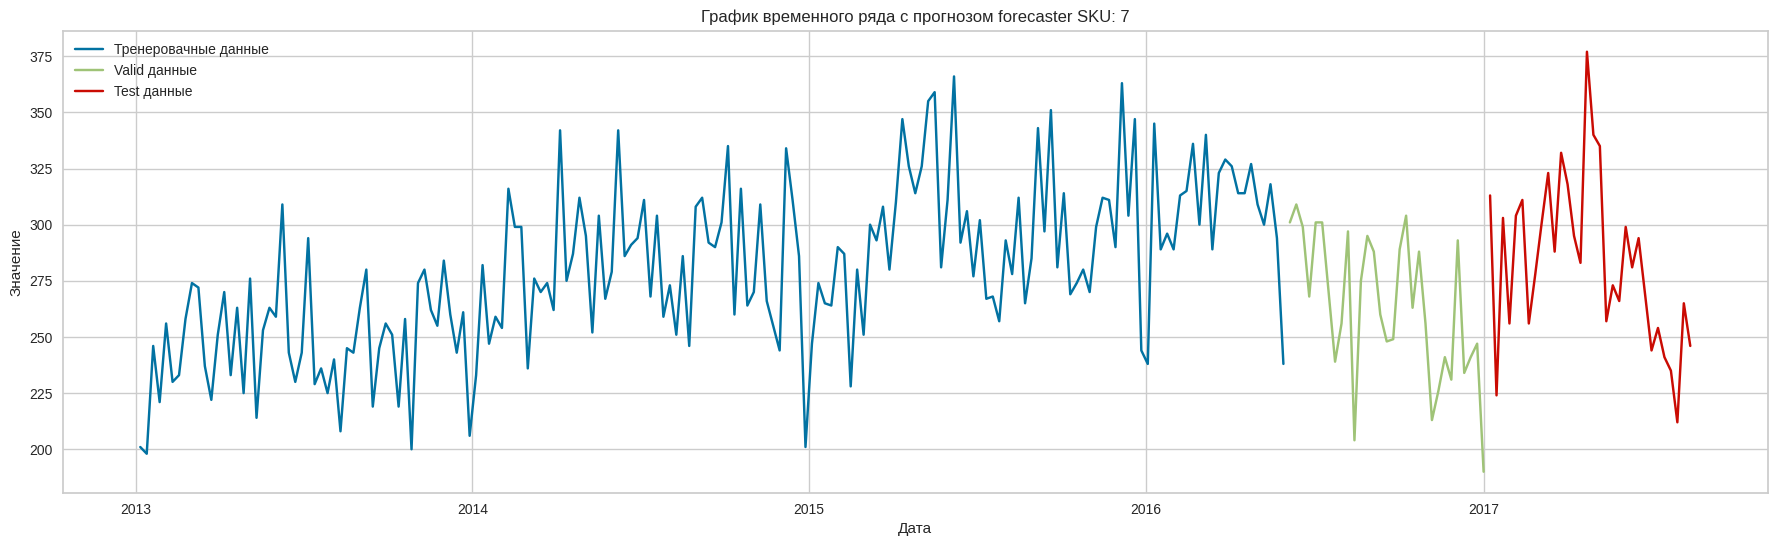

            unit_sales
date                  
2013-01-06       201.0
2013-01-13       198.0
2013-01-20       246.0
2013-01-27       221.0
2013-02-03       256.0
...                ...
2017-07-16       241.0
2017-07-23       235.0
2017-07-30       212.0
2017-08-06       265.0
2017-08-13       246.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


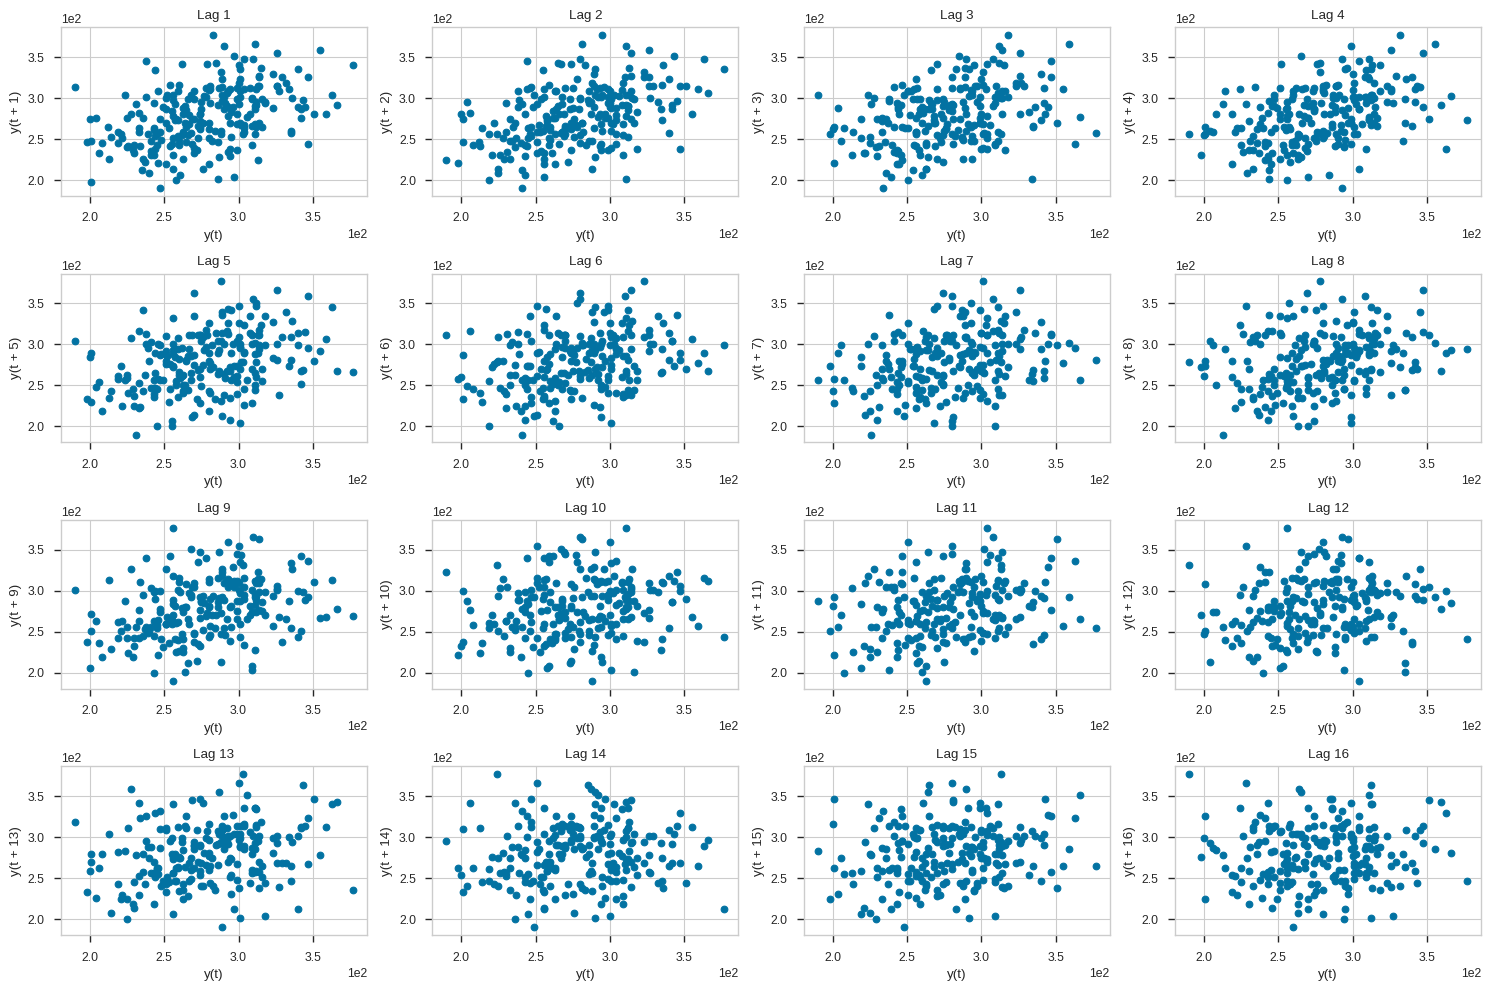

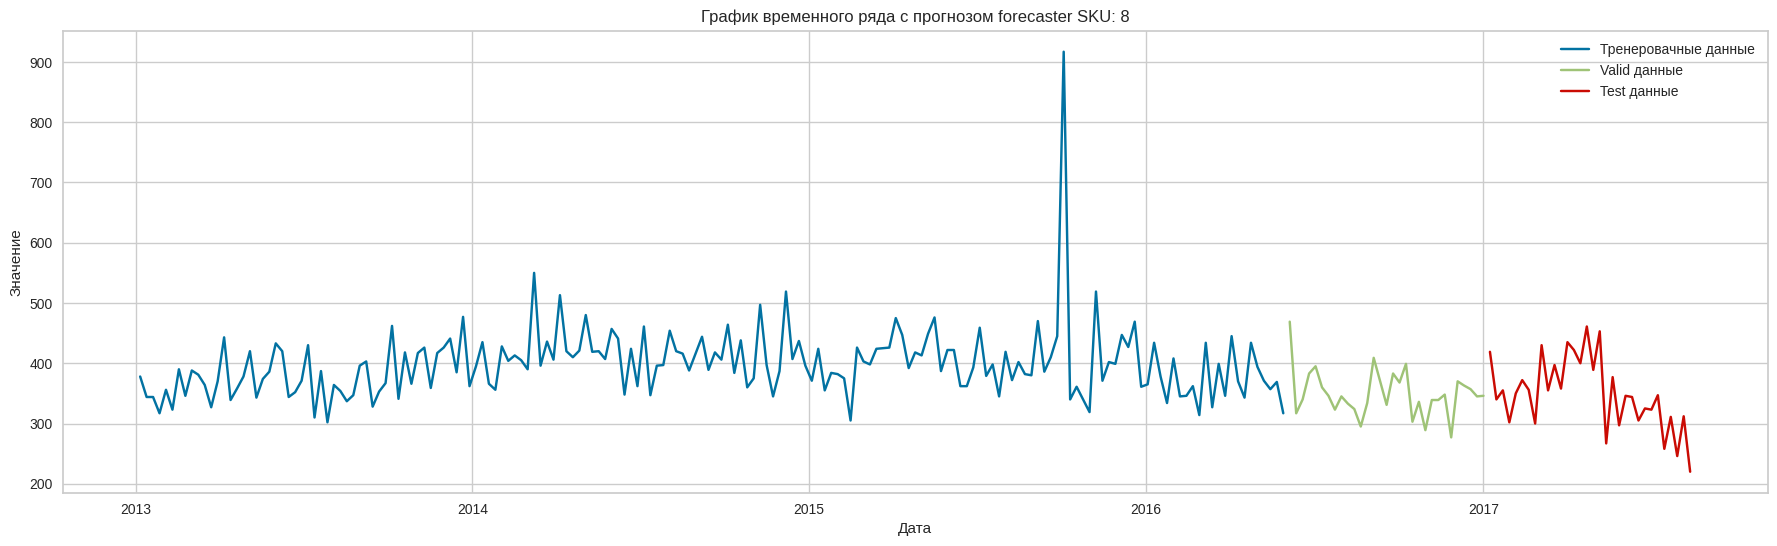

            unit_sales
date                  
2013-01-06       378.0
2013-01-13       344.0
2013-01-20       344.0
2013-01-27       317.0
2013-02-03       356.0
...                ...
2017-07-16       258.0
2017-07-23       311.0
2017-07-30       246.0
2017-08-06       312.0
2017-08-13       220.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


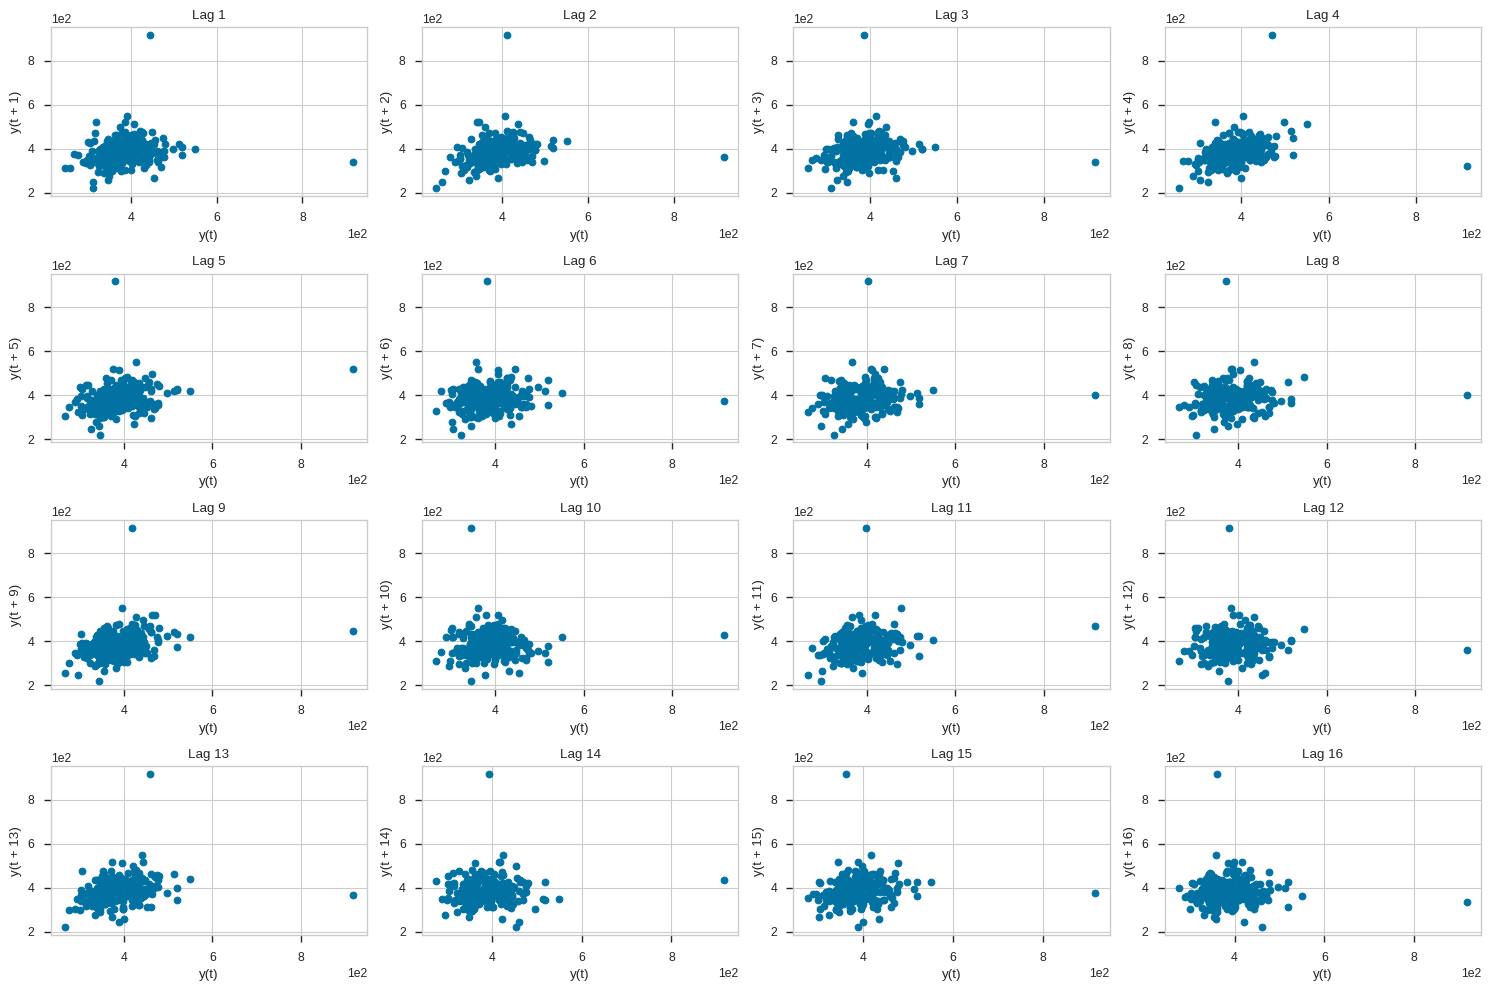

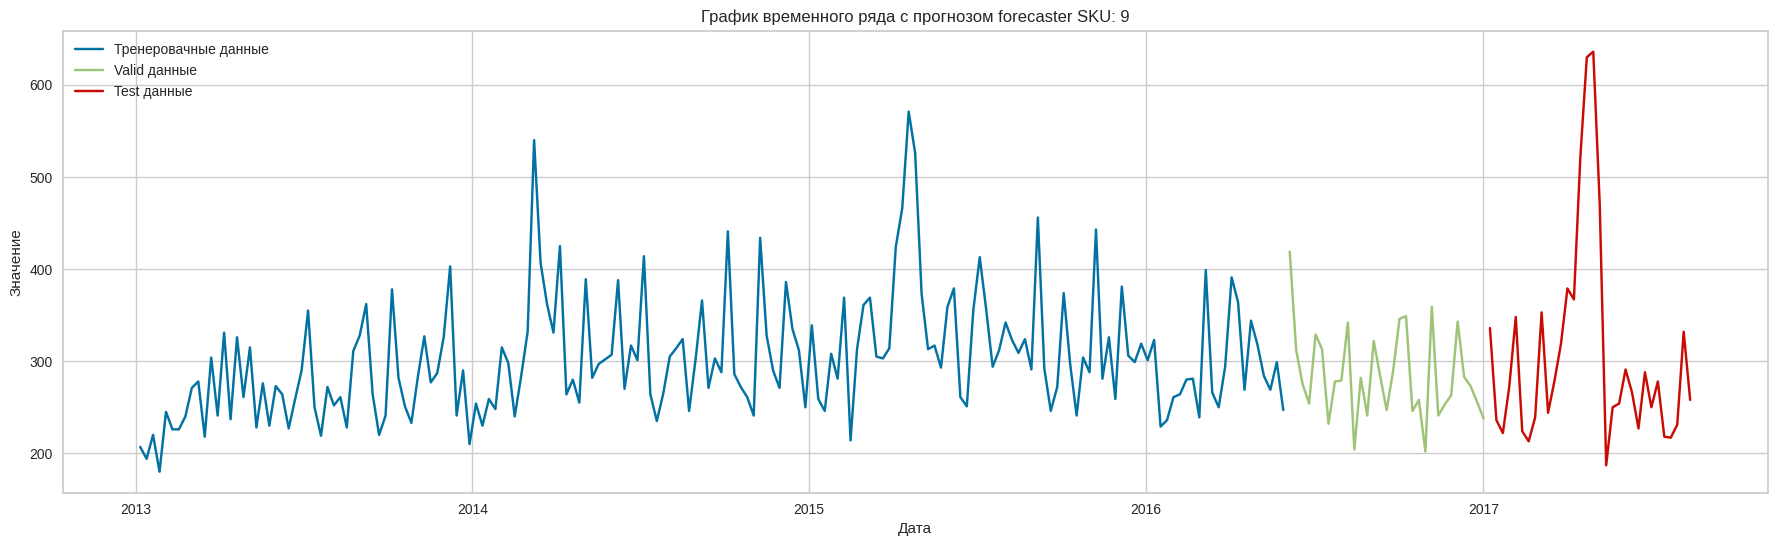

            unit_sales
date                  
2013-01-06       207.0
2013-01-13       194.0
2013-01-20       220.0
2013-01-27       180.0
2013-02-03       245.0
...                ...
2017-07-16       218.0
2017-07-23       217.0
2017-07-30       231.0
2017-08-06       332.0
2017-08-13       258.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


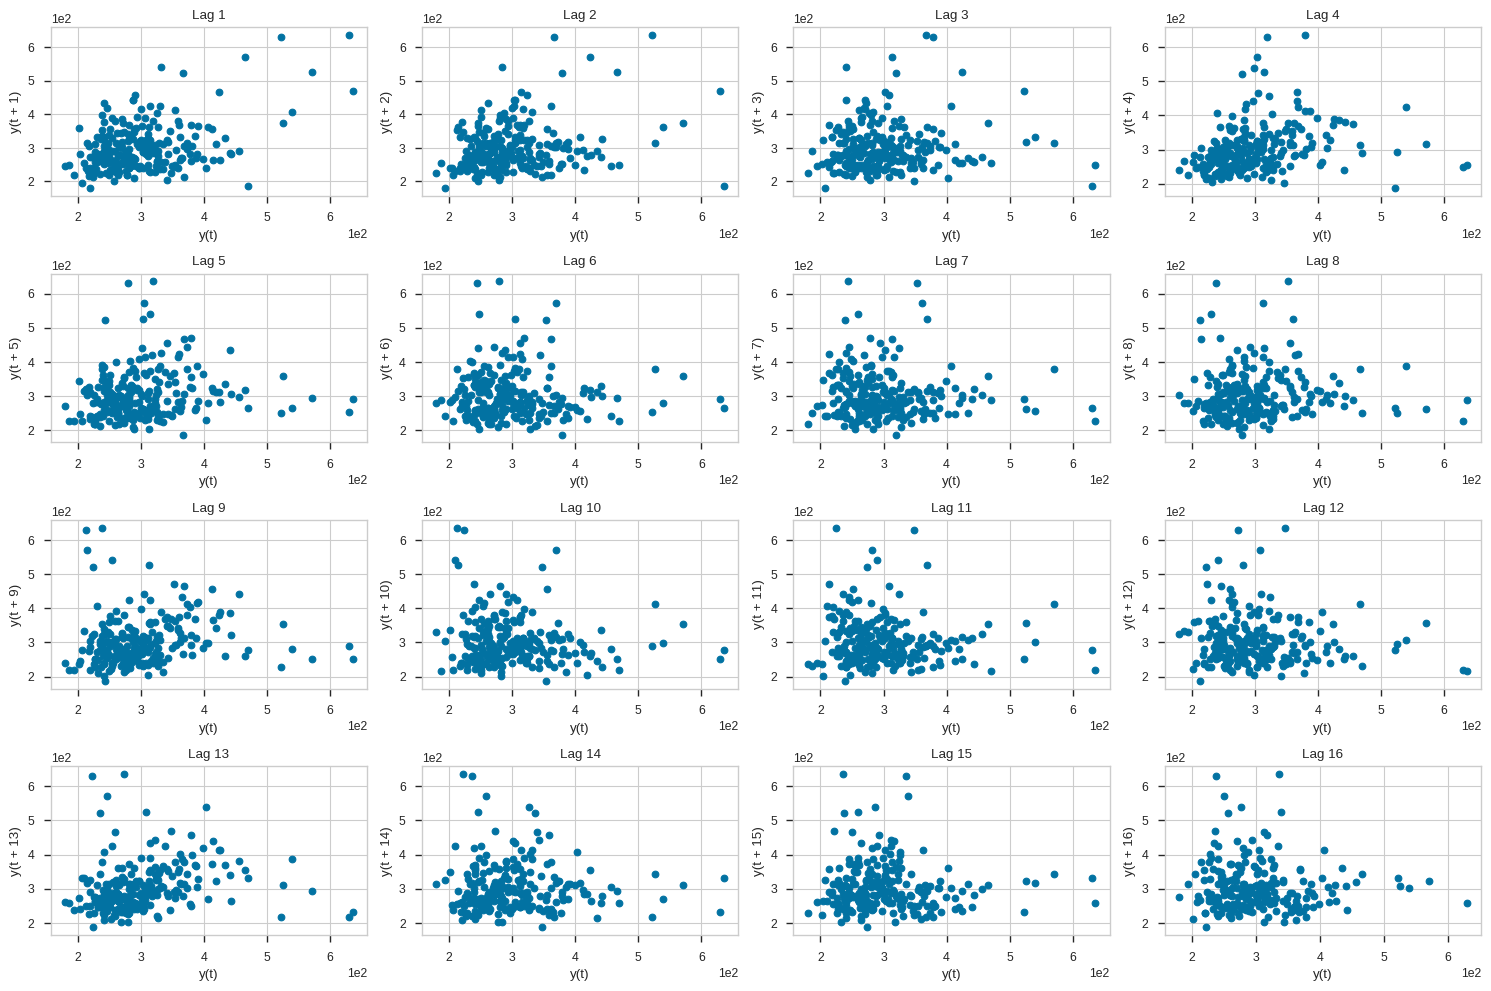

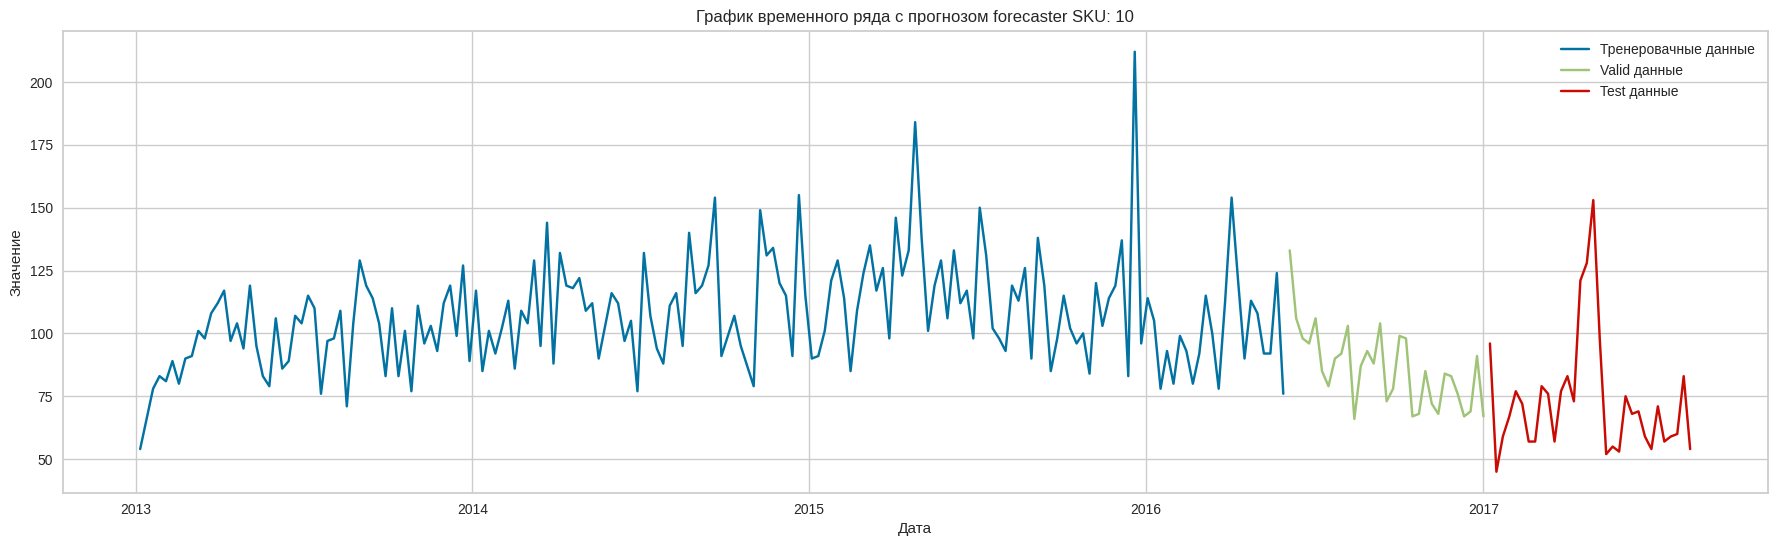

            unit_sales
date                  
2013-01-06        54.0
2013-01-13        66.0
2013-01-20        78.0
2013-01-27        83.0
2013-02-03        81.0
...                ...
2017-07-16        57.0
2017-07-23        59.0
2017-07-30        60.0
2017-08-06        83.0
2017-08-13        54.0

[241 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


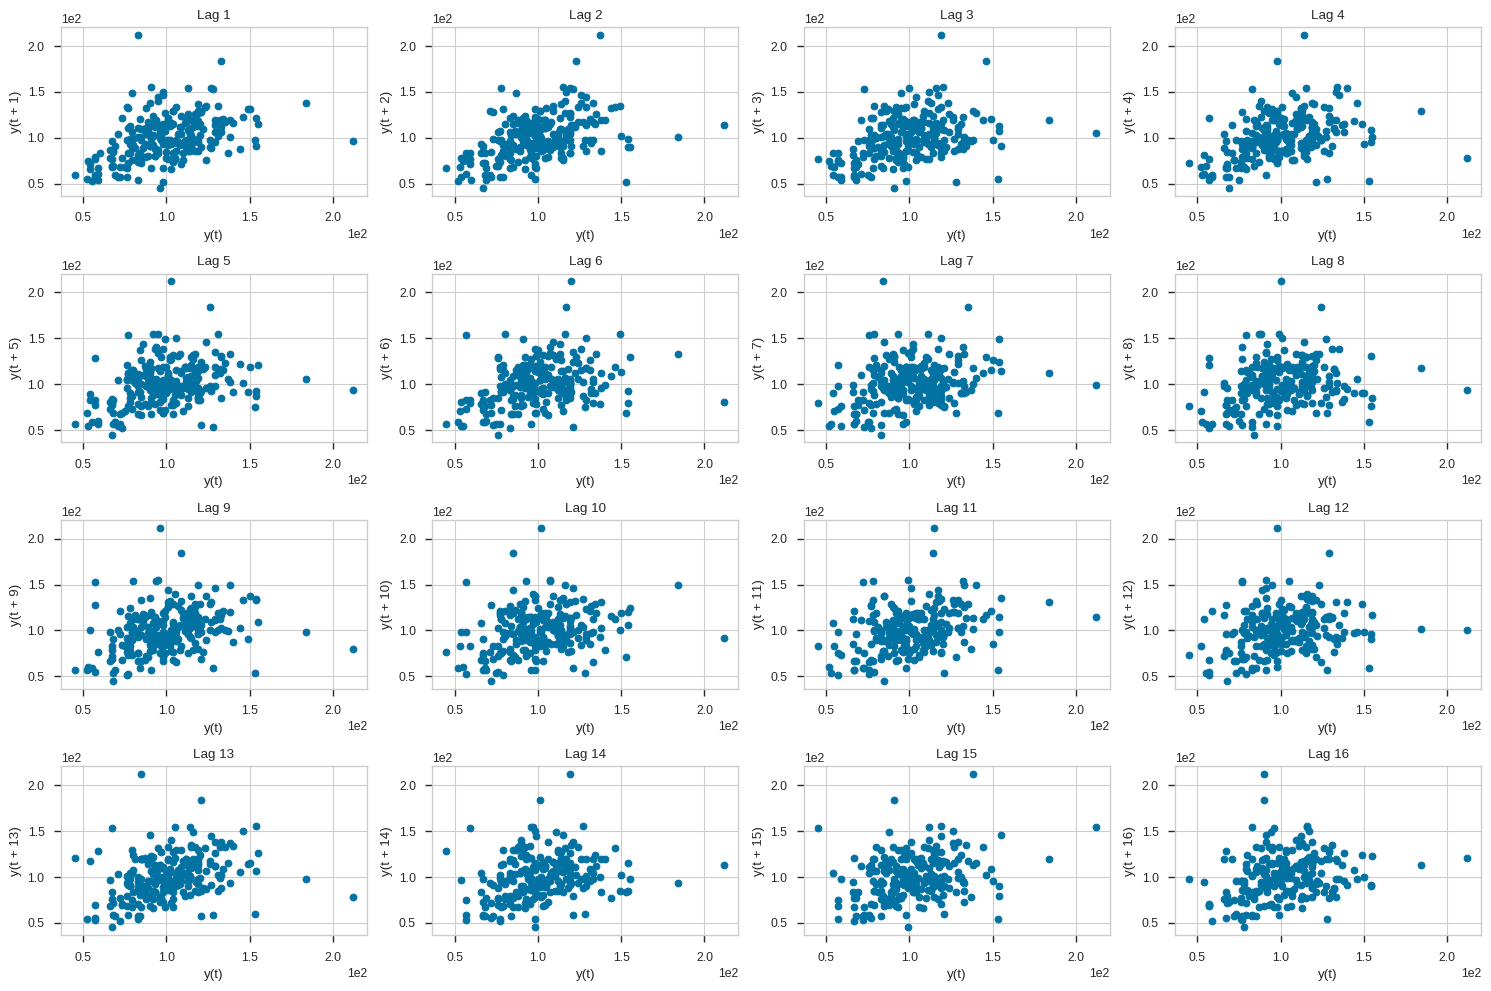

In [50]:
for sku in range(1,11):
    even_df = filtered_grouped_data[filtered_grouped_data['store_nbr']==sku][['date','unit_sales']]
    even_df['date'] = pd.to_datetime(even_df['date'])
    even_df = even_df.set_index('date')
    even_df = even_df.asfreq('D')
    weekly_df = even_df.resample('W').sum()


    func_model(weekly_df[:-1],sku)
    # static_stacionar(weekly_df[:-1], sku)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:443: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y1, y2, **kwds)


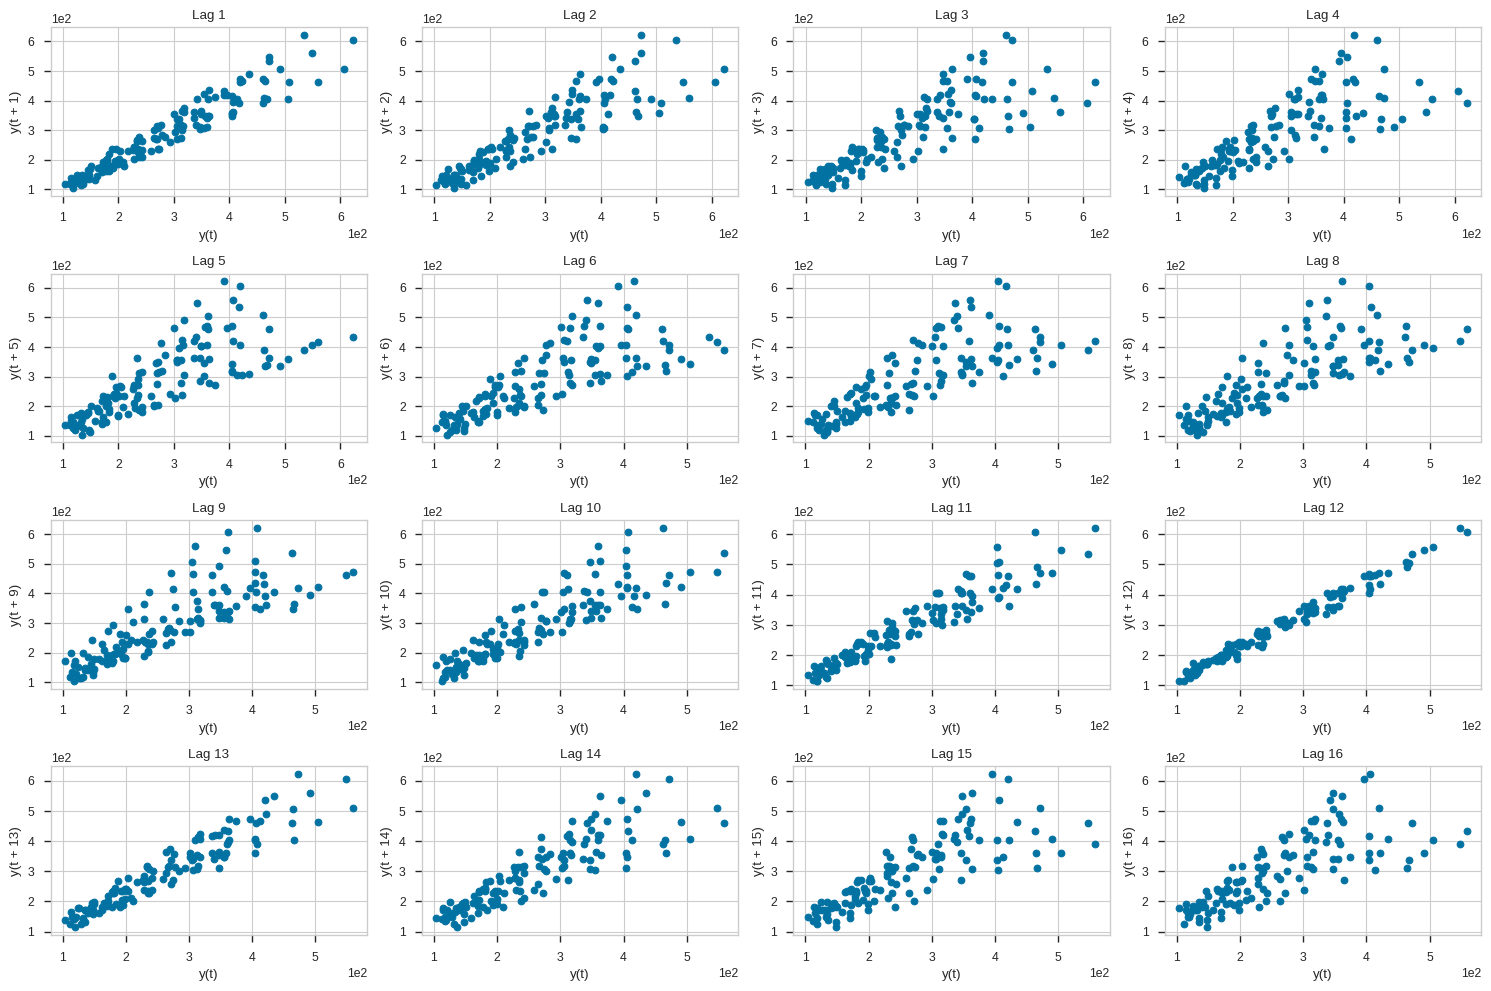

In [51]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()
data.head(4)
with sns.plotting_context("paper"):
      fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[15, 10])
      for i, ax_ in enumerate(ax.flatten()):
          pd.plotting.lag_plot(data, lag=i + 1, ax=ax_)

          ax_.set_title(f"Lag {i+1}")
          ax_.ticklabel_format(style="sci", scilimits=(0, 0))
      plt.tight_layout()

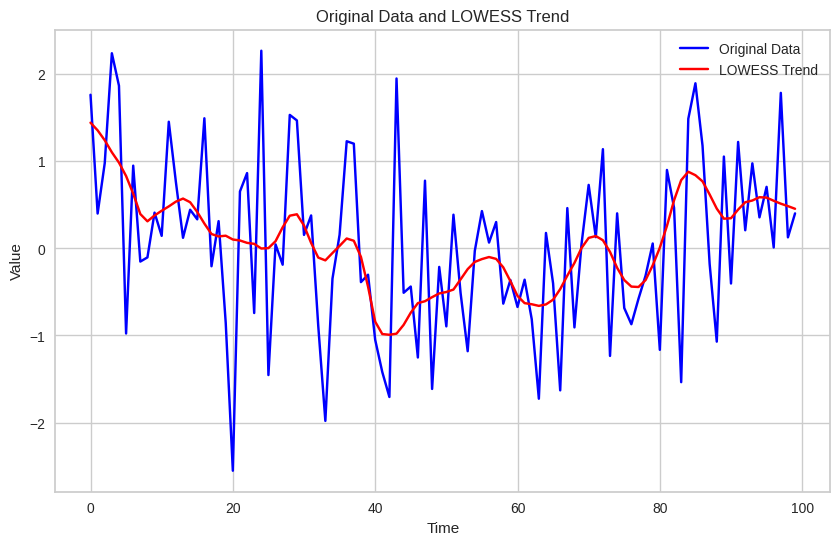

In [52]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

# Создаем пример временного ряда
np.random.seed(0)
n = 100
df = pd.DataFrame({'y': np.random.randn(n)})

# Вычисляем тренд с LOWESS
frac = 0.1
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Визуализация временного ряда и LOWESS тренда
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["y"], label='Original Data', color='blue')
plt.plot(df.index, df["lowess"], label='LOWESS Trend', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data and LOWESS Trend')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.168e+04
Date:                Thu, 22 Feb 2024   Prob (F-statistic):          1.39e-147
Time:                        10:41:23   Log-Likelihood:                -133.96
No. Observations:                 100   AIC:                             273.9
Df Residuals:                      97   BIC:                             281.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0631      0.276      3.854      0.0

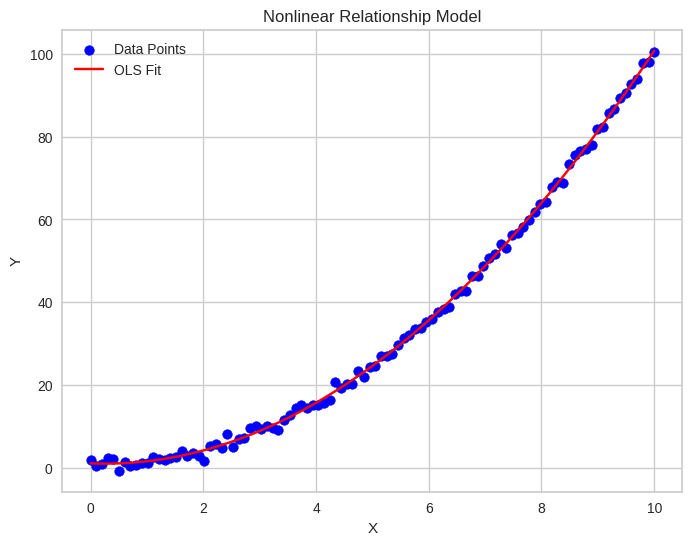

In [53]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Создание нелинейно зависимых данных
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = x**2 + np.random.normal(0, 1, 100)

# Добавление квадратичной функции в модель
X = sm.add_constant(np.column_stack((x, x**2)))
model = sm.OLS(y, X)

# Подгонка модели
results = model.fit()

# Вывод результатов
print(results.summary())

# Визуализация результата
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x, results.predict(), color='red', label='OLS Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nonlinear Relationship Model')
plt.legend()
plt.show()

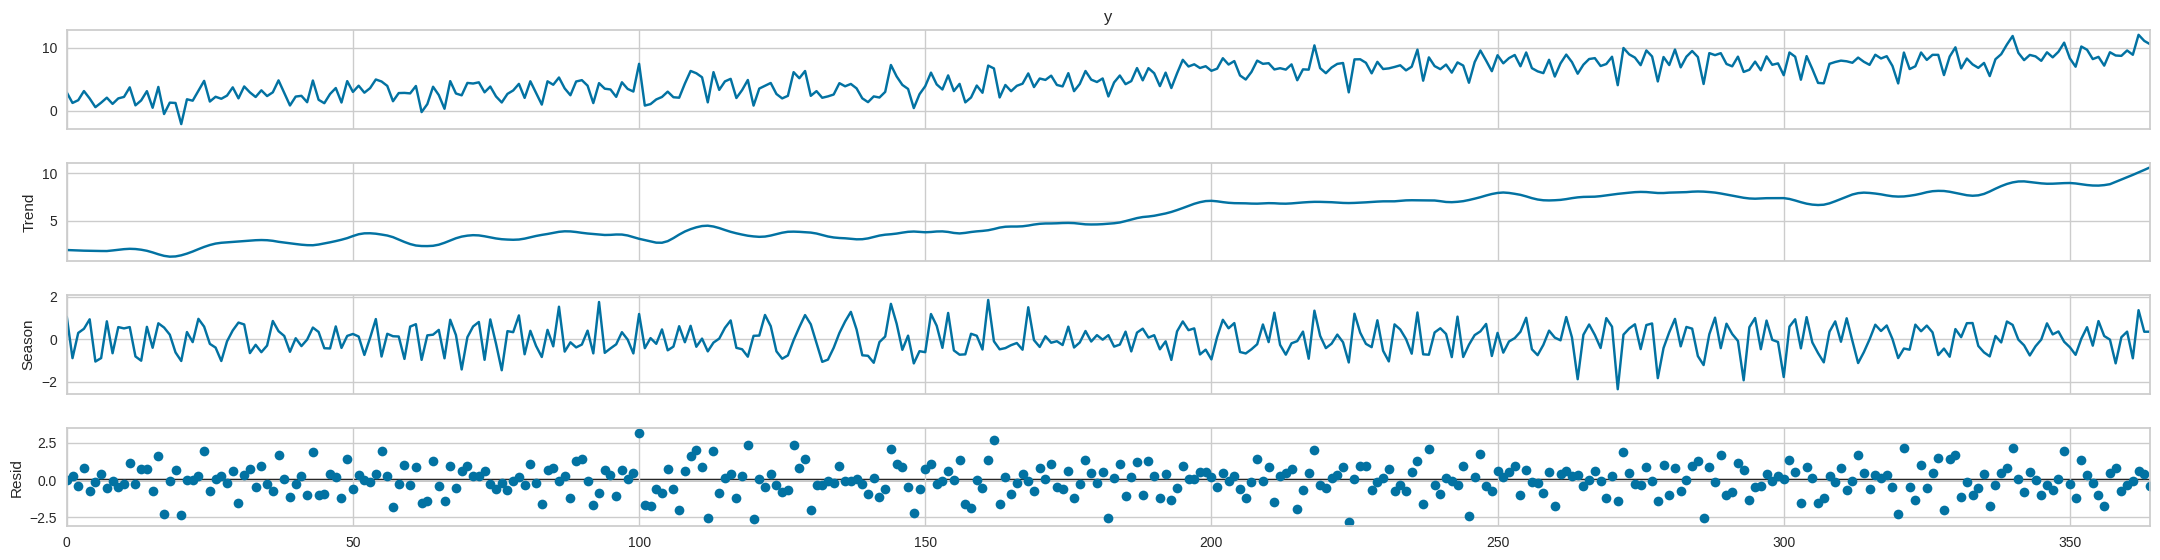

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Создание временного ряда с трендом и сезонностью
np.random.seed(0)
dates = pd.date_range(start='2022-01-01', periods=365)
trend = np.linspace(1, 10, 365) + np.random.normal(0, 1, 365)
seasonality = np.sin(np.linspace(0, 4*np.pi, 365))
residuals = np.random.normal(0, 1, 365)
df = pd.DataFrame({'date': dates, 'y': trend + seasonality + residuals})

# Декомпозиция временного ряда с указанием периода сезонности
res = STL(df["y"], period=7).fit()

# Визуализация полного разложения
plt.rc("figure", figsize=(22, 6))
plt.rc("font", size=20)
res.plot()
plt.show()

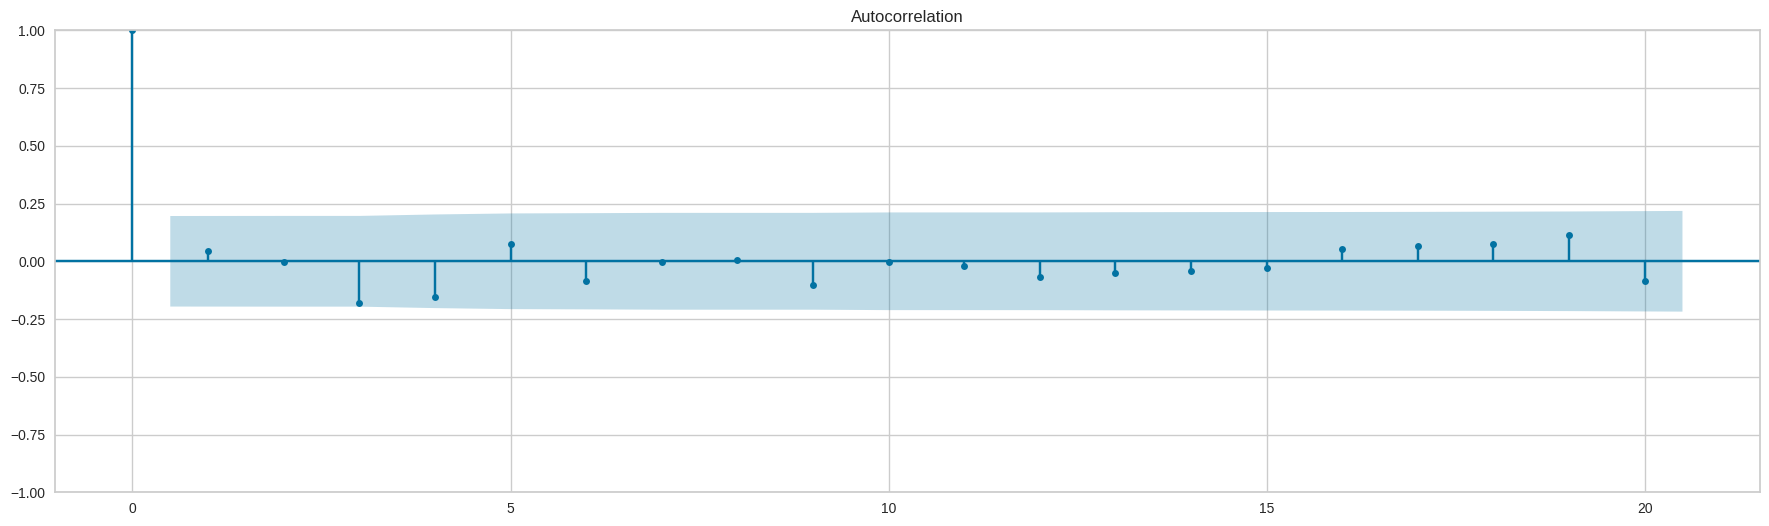

In [55]:
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Создаем случайный временной ряд
np.random.seed(42)
data = np.random.rand(100)

# Вычисляем автокорреляционную функцию с помощью acf
acf_values = acf(data)

# Визуализируем автокорреляционную функцию с помощью plot_acf
plot_acf(data)
plt.show()

In [56]:
acf_values

array([ 1.        ,  0.04541078, -0.00172813, -0.18055443, -0.154043  ,
        0.07685569, -0.08655105, -0.00117813,  0.00620259, -0.10105621,
       -0.00436099, -0.02153971, -0.06748099, -0.05004041, -0.04323529,
       -0.0288824 ,  0.05312666,  0.06753465,  0.07423803,  0.11484839,
       -0.08342027])

In [57]:
filtered_grouped_data


id        date  store_nbr  item_nbr  unit_sales onpromotion
793              793  2013-01-02          1    314384        41.0         NaN
1820            1820  2013-01-02          2    314384        69.0         NaN
2943            2943  2013-01-02          3    314384       143.0         NaN
4126            4126  2013-01-02          4    314384        71.0         NaN
5169            5169  2013-01-02          5    314384        82.0         NaN
...              ...         ...        ...       ...         ...         ...
125405050  125405050  2017-08-15          6    314384        46.0        True
125407310  125407310  2017-08-15          7    314384        42.0        True
125409589  125409589  2017-08-15          8    314384        46.0        True
125411984  125411984  2017-08-15          9    314384        35.0        True
125414089  125414089  2017-08-15         10    314384        15.0        True

[16786 rows x 6 columns]

Text(0.5, 0, 'Time')

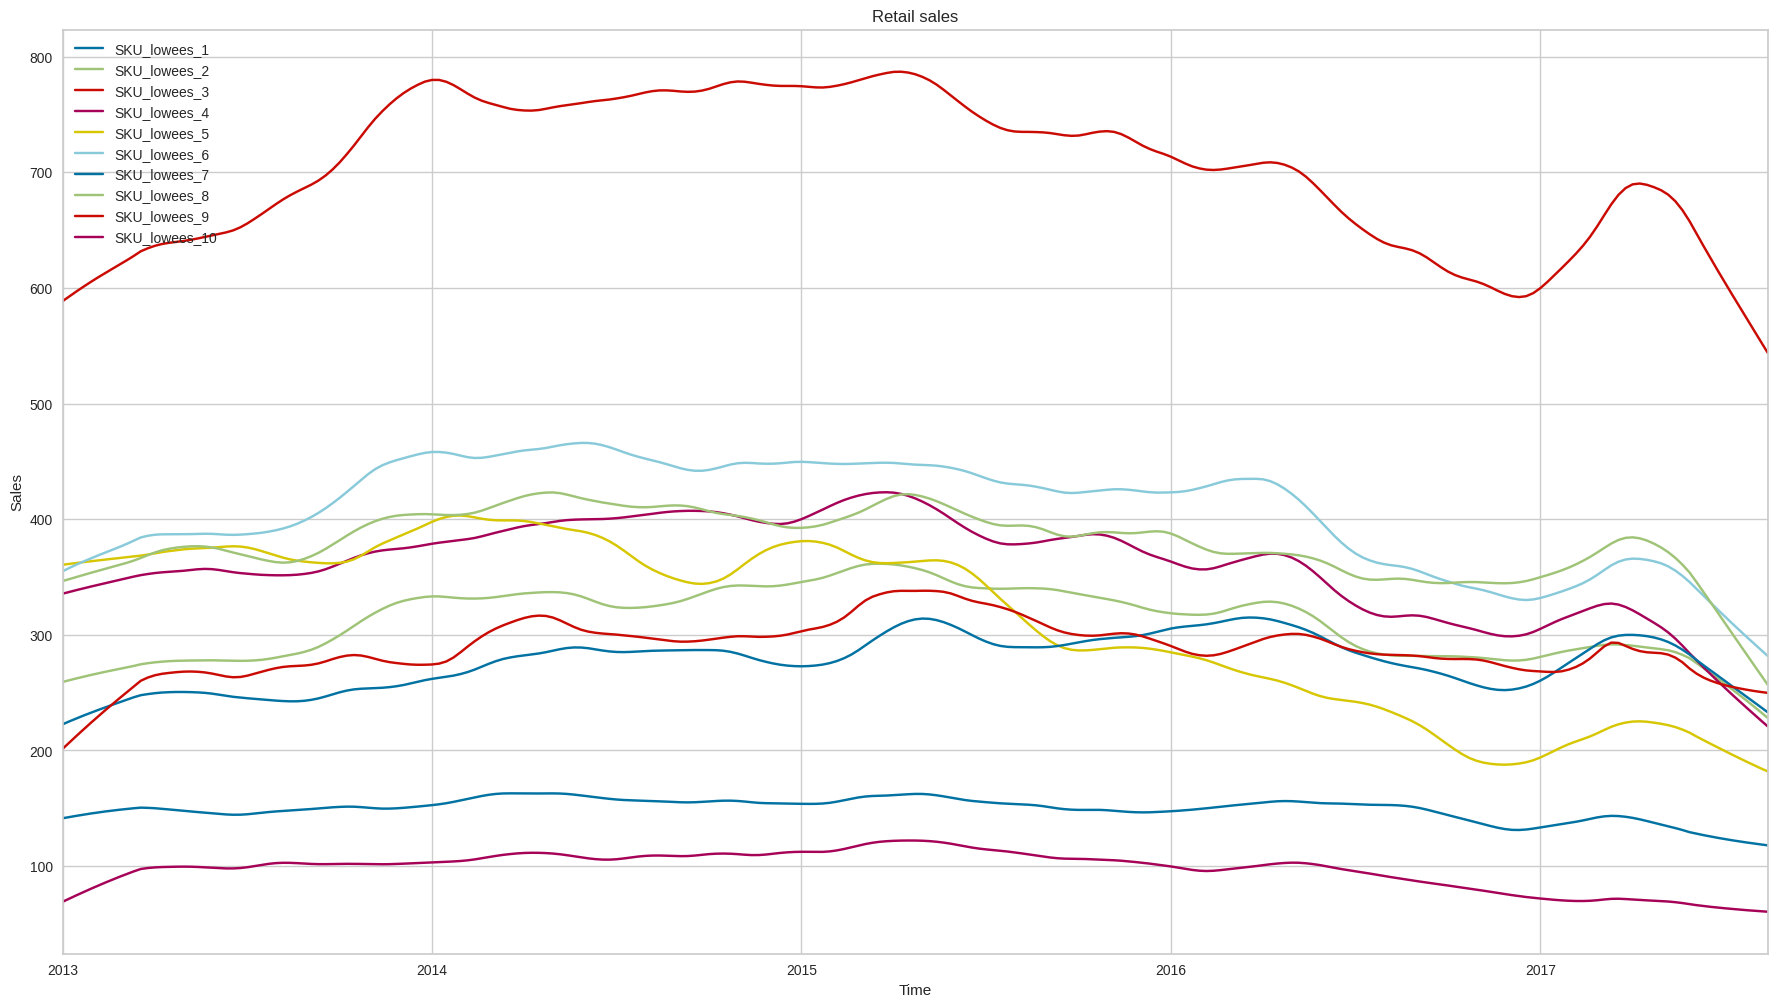

In [58]:
from statsmodels.nonparametric.smoothers_lowess import lowess
lws_pd = pd.DataFrame()

for sku in range(1,11):
    even_df = filtered_grouped_data[filtered_grouped_data['store_nbr']==sku][['date','unit_sales']]
    even_df['date'] = pd.to_datetime(even_df['date'])
    even_df = even_df.set_index('date')
    even_df = even_df.asfreq('D')
    weekly_df = even_df.resample('W').sum()
    weekly_df.columns = [f'SKU_{sku}']
    weekly_df = weekly_df[:-1]

    lws = lowess(endog=weekly_df[f'SKU_{sku}'],exog=range(len(weekly_df)),frac=0.1)
    weekly_df[f'SKU_lowees_{sku}']=lws[:, 1]
    lws_pd[f'SKU_lowees_{sku}'] = lws[:, 1]

    # ax = weekly_df.plot(figsize=(10, 5))
    # ax.set_title("Retail sales")
    # ax.set_ylabel("Sales")
    # ax.set_xlabel("Time")



lws_pd.index = pd.date_range(start='2013-01-02', end='2017-08-15', freq='W')

ax = lws_pd.plot(figsize=(22, 12))
ax.set_title("Retail sales")
ax.set_ylabel("Sales")
ax.set_xlabel("Time")


In [59]:
import pandas as pd
import numpy as np

# Создаем пример DataFrame с пропущенными значениями
data = pd.DataFrame({
    'A': [1, 2, np.nan, np.nan, np.nan],
    'B': [np.nan, 10, 20, np.nan, 50]
})

# Выводим исходные данные
print("Исходные данные:")
print(data)

# Заполняем пропущенные значения методом "ffill"
data = data.fillna(method='ffill')

# Выводим данные после заполнения
print("\nДанные после заполнения пропущенных значений методом 'ffill':")
print(data)

Исходные данные:
     A     B
0  1.0   NaN
1  2.0  10.0
2  NaN  20.0
3  NaN   NaN
4  NaN  50.0

Данные после заполнения пропущенных значений методом 'ffill':
     A     B
0  1.0   NaN
1  2.0  10.0
2  2.0  20.0
3  2.0  20.0
4  2.0  50.0


              y
2022-01-01   38
2022-01-02  236
2022-01-03  909
2022-01-04   73
2022-01-05  768
2022-01-06  906
2022-01-07  716
2022-01-08  646
2022-01-09  848
2022-01-10  961
                  3-MA
2022-01-01         NaN
2022-01-02  394.333333
2022-01-03  406.000000
2022-01-04  583.333333
2022-01-05  582.333333


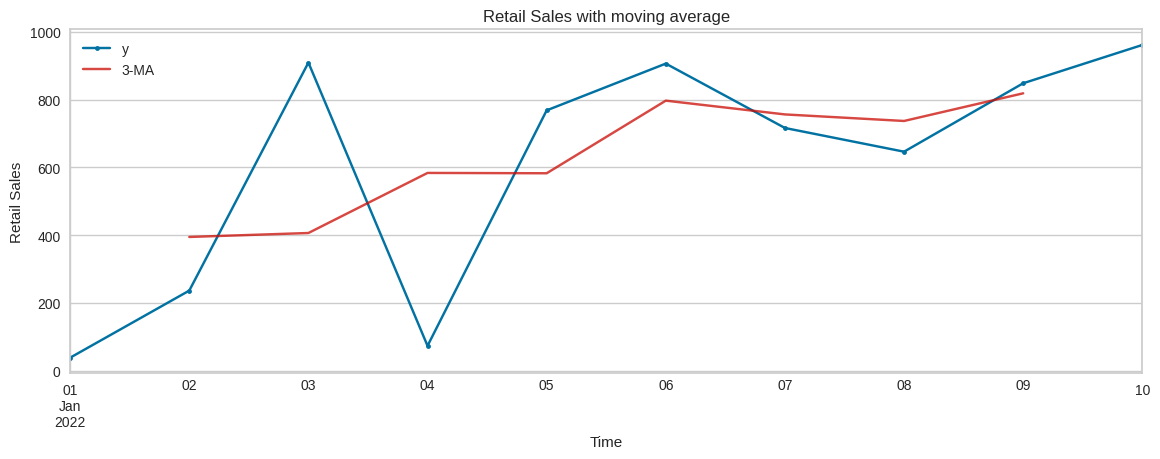

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
np.random.seed(1)

# Создание временных индексов
date_range = pd.date_range(start='2022-01-01', periods=10)

# Создание DataFrame с случайными данными
df = pd.DataFrame({
    "y": np.random.randint(1, 1000, size=10)
}, index=date_range)

# Расчет скользящего среднего
window_size = 3
ma_3 = df.rolling(
    window=window_size,
    center=True
).mean()

# Переименование столбца
ma_3.rename(columns={"y": "3-MA"}, inplace=True)

print(df)
print(ma_3.head())
# Plot the result
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")
ma_3.plot(ax=ax, color="r", alpha=0.75)

ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales with moving average")
plt.tight_layout()

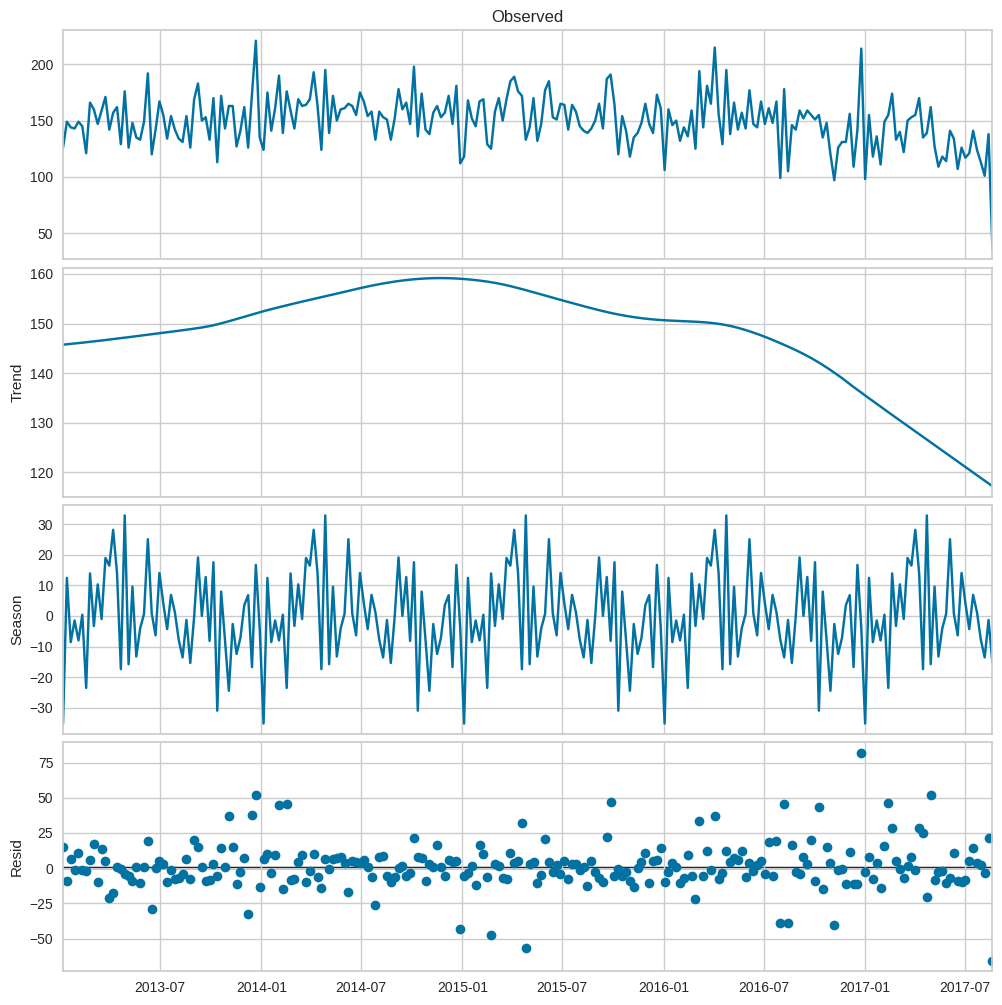

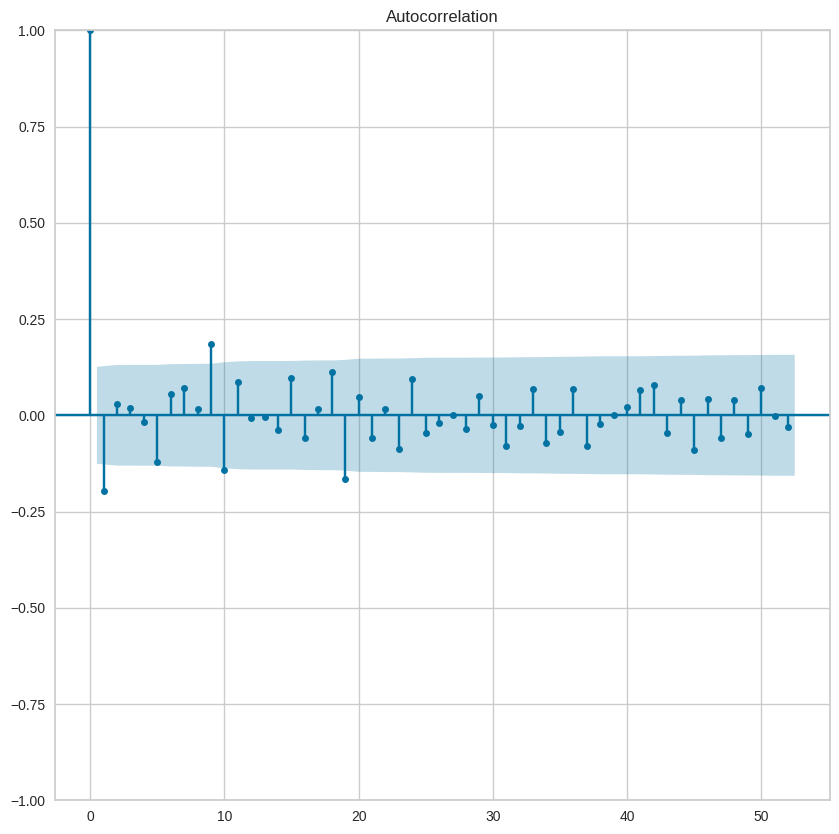

                y       trend   seasonal  y_detrended
date                                                 
2013-01-06  126.0  145.732850 -35.101583   -19.732850
2013-01-13  149.0  145.809171  12.435329     3.190829
2013-01-20  144.0  145.887317  -8.537971    -1.887317
2013-01-27  143.0  145.967302  -1.478370    -2.967302
2013-02-03  149.0  146.049123  -7.980933     2.950877
...           ...         ...        ...          ...
2017-07-23  124.0  119.401979   1.215858     4.598021
2017-07-30  113.0  118.850008  -7.740970    -5.850008
2017-08-06  101.0  118.298743 -13.523969   -17.298743
2017-08-13  138.0  117.748237  -1.297161    20.251763
2017-08-20   36.0  117.198542 -15.342215   -81.198542

[242 rows x 4 columns]


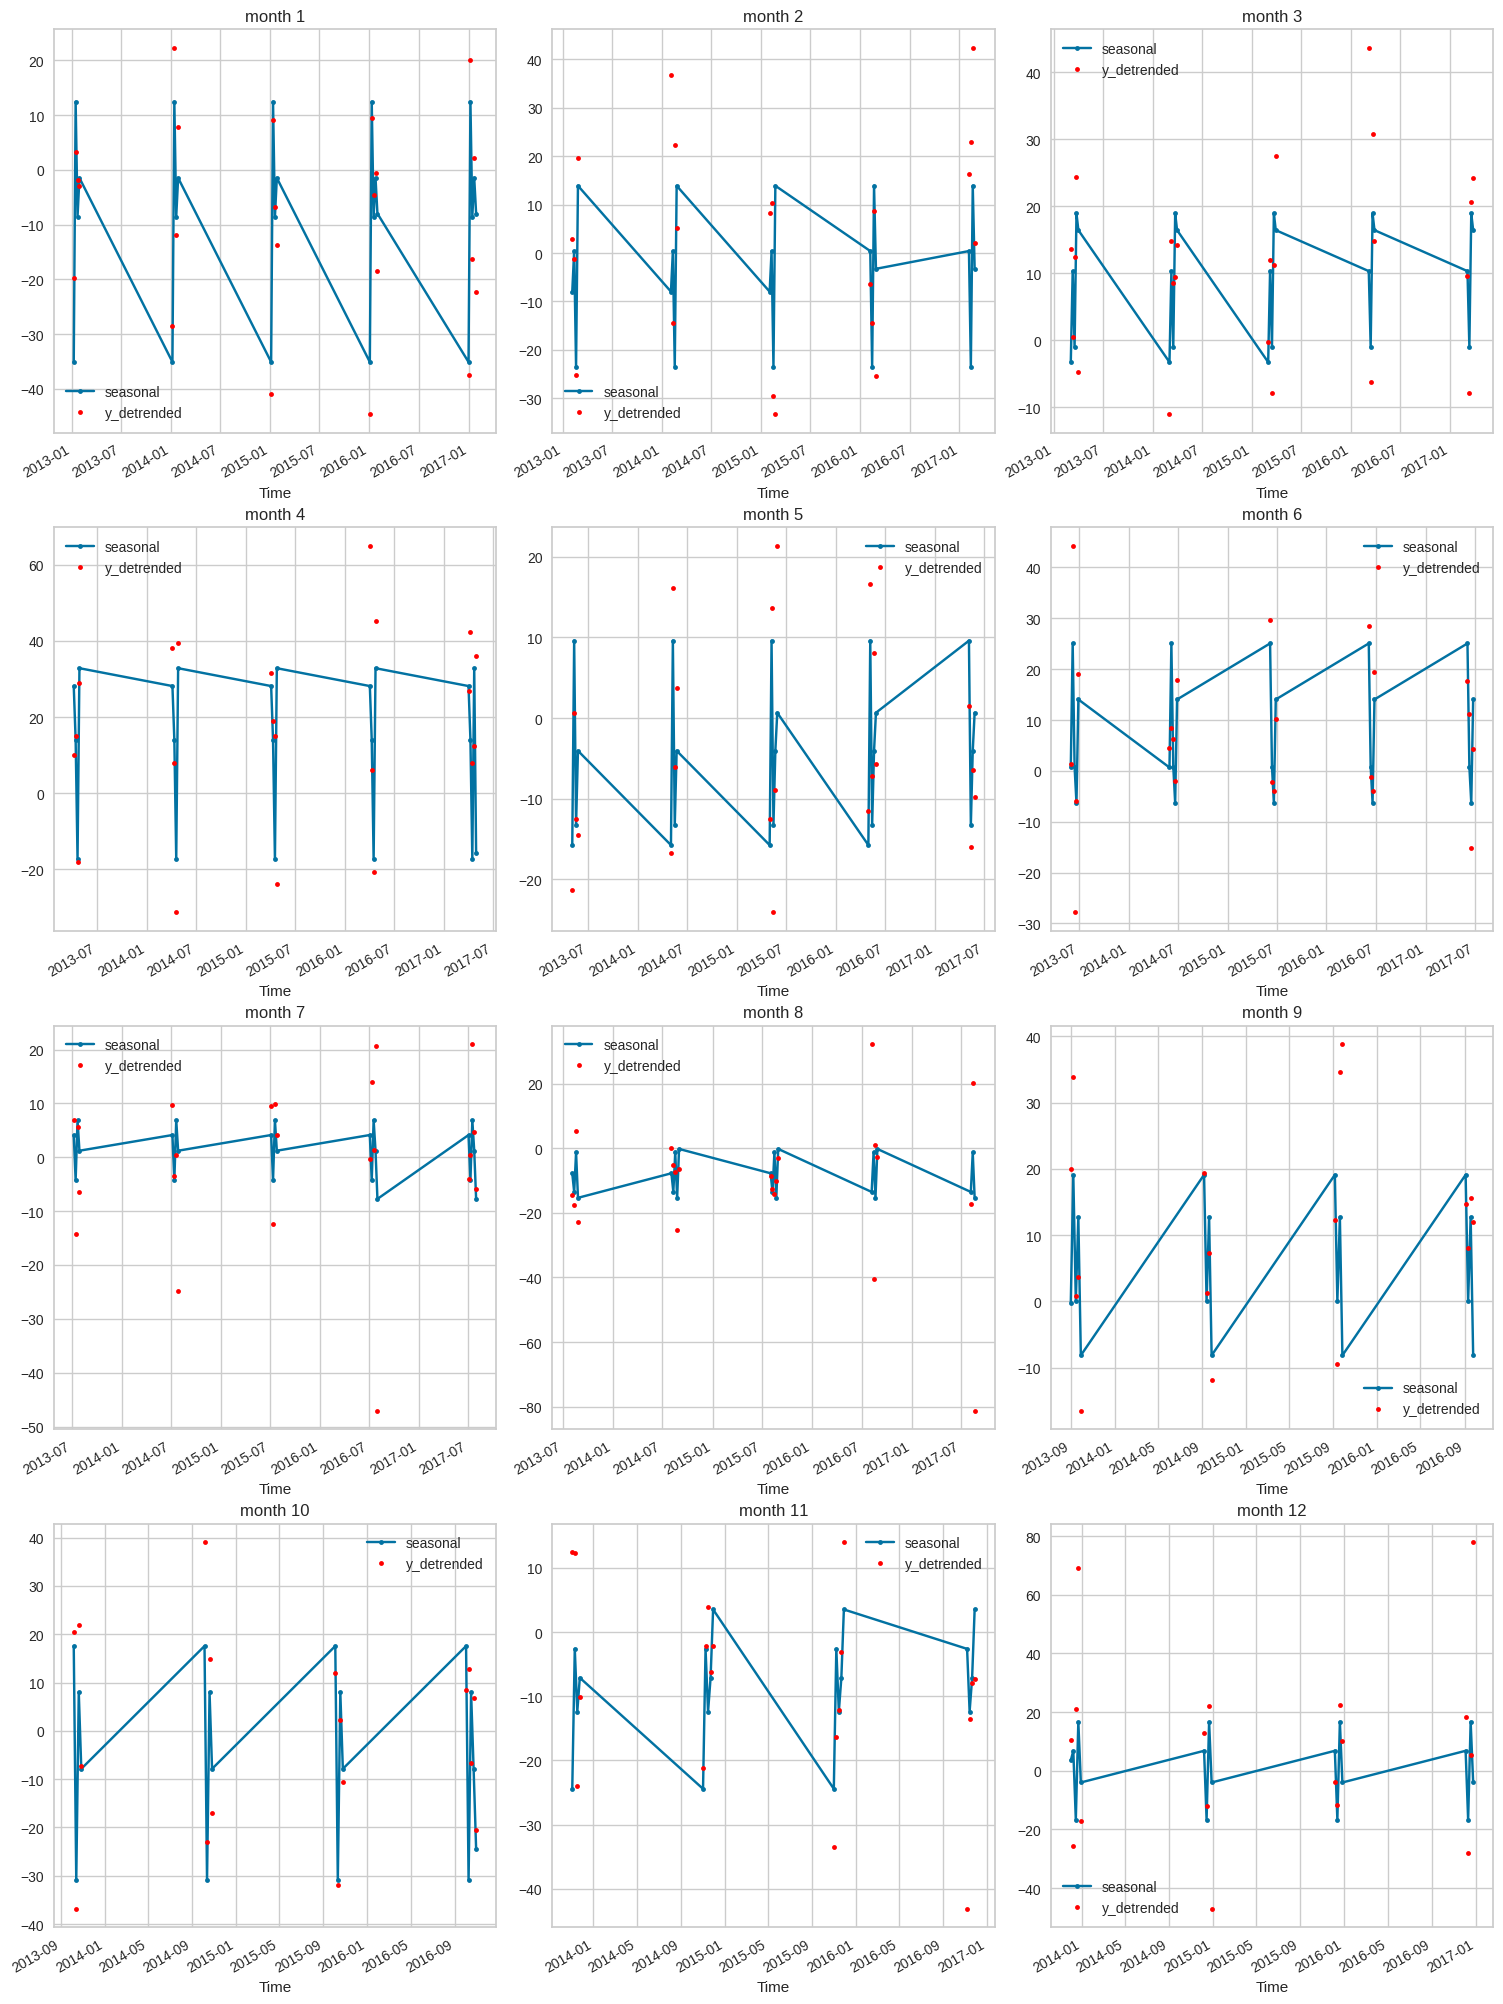

In [104]:
for sku in range(1,2):
    even_df = filtered_grouped_data[filtered_grouped_data['store_nbr']==sku][['date','unit_sales']]
    even_df['date'] = pd.to_datetime(even_df['date'])
    even_df = even_df.set_index('date')
    even_df = even_df.asfreq('D')
    weekly_df = even_df.resample('W').sum()
    # print(weekly_df)

    res = STL(
    endog=weekly_df,  # Y values
    period=52,  # The periodicity of the seasonal component
    seasonal=1001,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    seasonal_deg=0,  # Fit a constant value (i.e., flat line) rather
    # than linear regression during LOESS smoothing
    # of seasonal component
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
    ).fit()
    # Plot the full decomposition
    plt.rc("figure", figsize=(10, 10))
    plt.rc("font", size=5)
    res.plot();
    # Вычисляем автокорреляционную функцию с помощью acf
    acf_values = acf(weekly_df)

    # Визуализируем автокорреляционную функцию с помощью plot_acf
    plot_acf(res.resid,lags=52)
    plt.show()
    df = pd.DataFrame()
    df['y']= weekly_df
    df["trend"] = res.trend
    df["seasonal"] = res.seasonal
    df["y_detrended"] = df["y"] - df["trend"]
    print(df)

    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 20])
    ax = ax.flatten()
    for i in range(0, 12):
        df[df.index.month == i + 1].plot(y="seasonal", marker=".", ax=ax[i])
        df[df.index.month == i + 1].plot(
            y="y_detrended", marker=".", linestyle="", ax=ax[i], color='red'
        )
        ax[i].set_title(f"month {i+1}")
        ax[i].set_xlabel("Time")

    plt.tight_layout()
    # func_model(weekly_df[:-1],sku)
    # # static_stacionar(weekly_df[:-1], sku)

            unit_sales
date                  
2013-01-06       126.0
2013-01-13       149.0
2013-01-20       144.0
2013-01-27       143.0
2013-02-03       149.0
...                ...
2017-07-23       124.0
2017-07-30       113.0
2017-08-06       101.0
2017-08-13       138.0
2017-08-20        36.0

[242 rows x 1 columns]


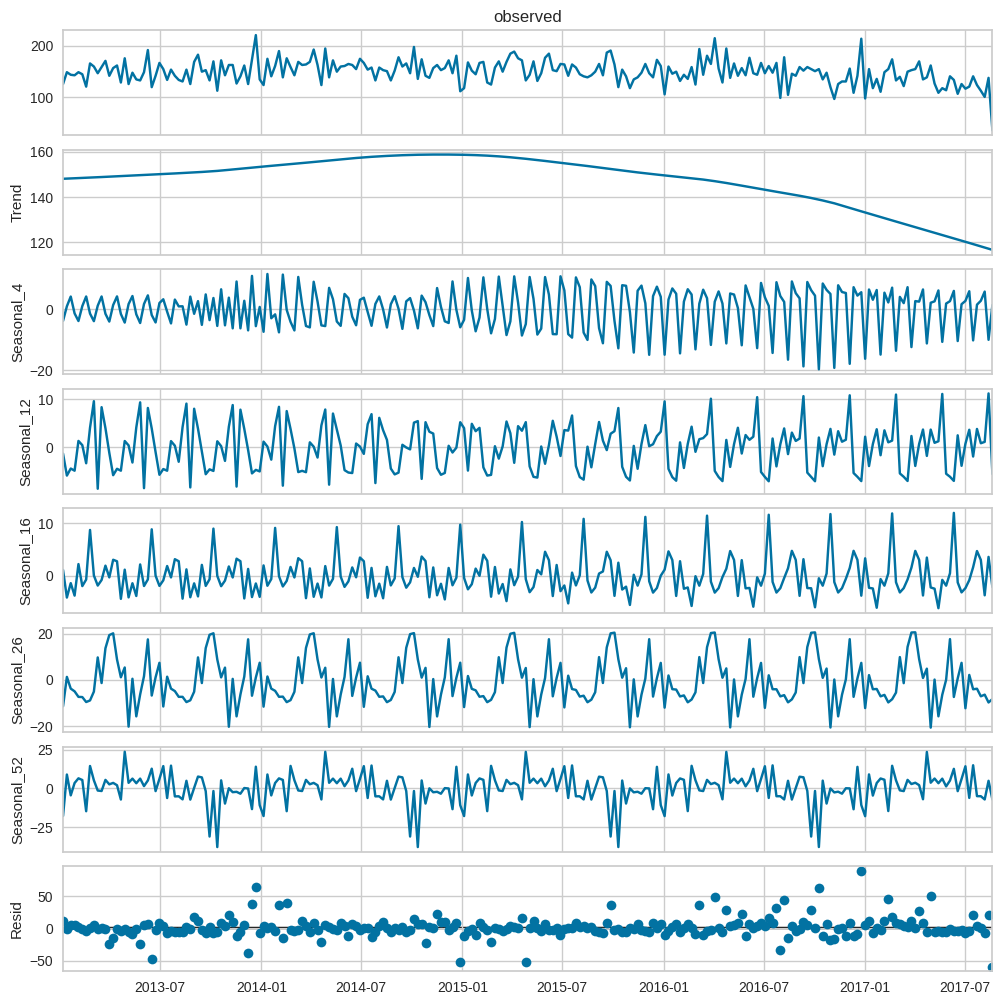

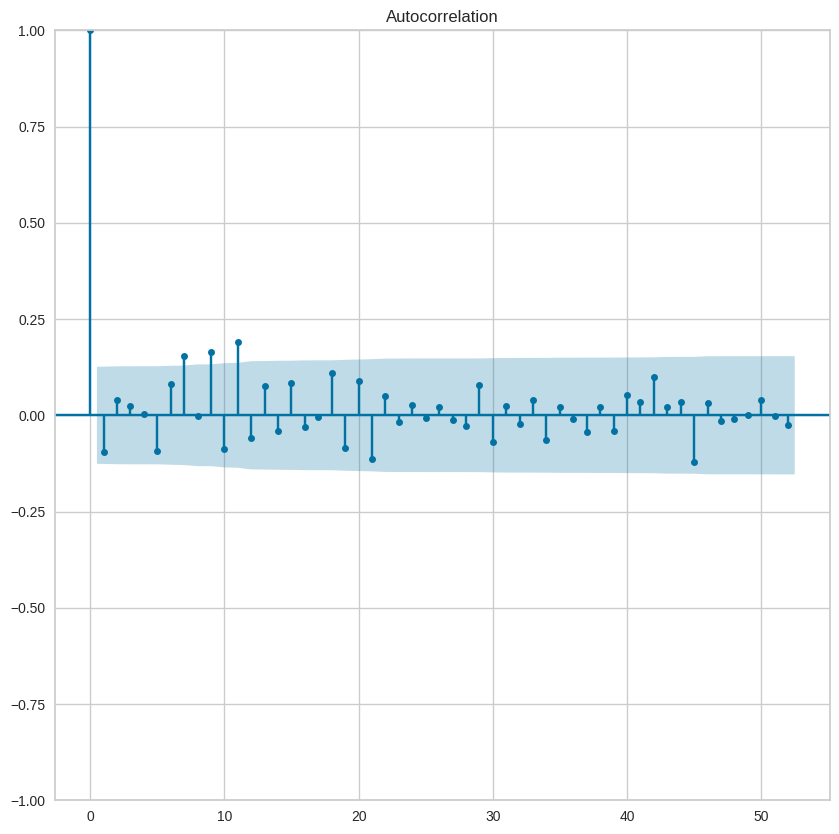

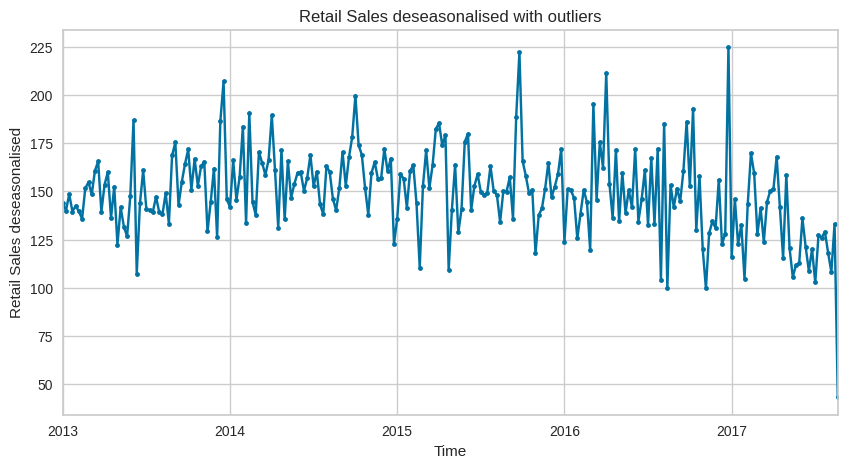

In [151]:
from statsmodels.tsa.seasonal import MSTL
for sku in range(1,2):
    even_df = filtered_grouped_data[filtered_grouped_data['store_nbr']==sku][['date','unit_sales']]
    even_df['date'] = pd.to_datetime(even_df['date'])
    even_df = even_df.set_index('date')
    even_df = even_df.asfreq('D')
    weekly_df = even_df.resample('W').sum()
    print(weekly_df)

    mstl = MSTL(weekly_df, periods=(4,12,16, 26,4*13,),
                # windows=(101,101,101, 101,101),
                # lmbda = 'auto',
                stl_kwargs={"seasonal_deg": 0,"robust":True})
    res = mstl.fit()
    # Plot the full decomposition
    plt.rc("figure", figsize=(10, 10))
    plt.rc("font", size=5)
    res.plot();
    acf_values = acf(weekly_df)

    # Визуализируем автокорреляционную функцию с помощью plot_acf
    plot_acf(res.resid,lags=52)
    plt.show()


        # Compute residuals
    df_ =pd.DataFrame()


    df_["y"] = weekly_df
    df_["season_52"]= res.seasonal['seasonal_52']
    df_["trend"] = res.trend

    df_["residual"] = df_["y"] - df_["season_52"]

    fig, ax = plt.subplots(figsize=[10, 5])

    df_.plot(y="residual", marker=".", figsize=[10, 5], legend=None, ax=ax)
    ax.set_title("Retail Sales deseasonalised with outliers")
    ax.set_ylabel("Retail Sales deseasonalised")
    ax.set_xlabel("Time")

    # Compute inter-quartile range
    Q1 = df_["residual"].quantile(0.25)
    Q3 = df_["residual"].quantile(0.75)
    IQR = Q3 - Q1

    # Apply 1.5 IQR as a threshold to identify outliers
    factor = 1.5
    df_["lower"] = Q1 - factor * IQR
    df_["upper"] = Q3 + factor * IQR
    df_["is_outlier"] = (df_["residual"] < df_["lower"]) | (
        df_["residual"] > df_["upper"]
    )




    # func_model(weekly_df[:-1],sku)
    # # static_stacionar(weekly_df[:-1], sku)

In [125]:
er = pd.DataFrame({'a': [np.nan,2,3,4,np.nan]})
n_missing = er["a"].isnull()
n_missing

0     True
1    False
2    False
3    False
4     True
Name: a, dtype: bool

In [126]:
1e6

1000000.0

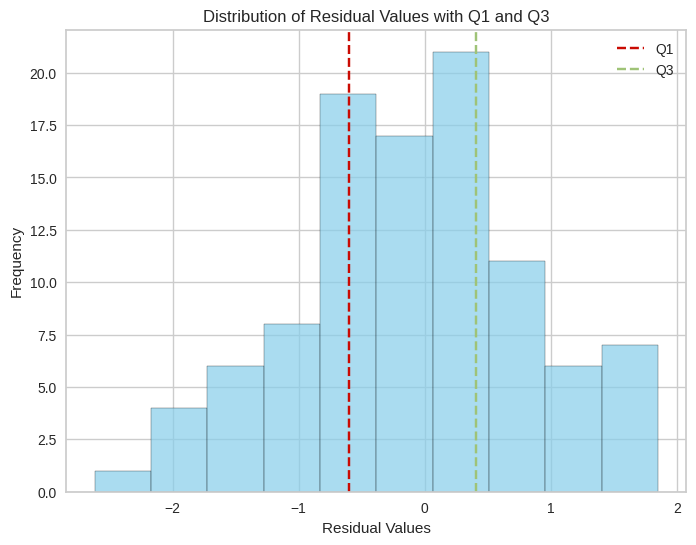

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Создаем пример данных
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=100)
df_ = pd.DataFrame(data, columns=["residual"])

# Вычисляем Q1, Q3 и IQR
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
Q2 = df_["residual"].quantile(0.50)
IQR = Q3 - Q1
factor = 1.5
df_["lower"] = Q1 - factor * IQR
df_["upper"] = Q3 + factor * IQR


# Визуализируем данные и квартили
plt.figure(figsize=(8, 6))
plt.hist(df_["residual"], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(Q1, color='r', linestyle='--', label='Q1')
plt.axvline(Q3, color='g', linestyle='--', label='Q3')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Residual Values with Q1 and Q3')
plt.show()

In [128]:
Q1

-0.6009056704964529

In [129]:
Q3

0.40595205201206214

In [131]:
Q2

-0.1269562917797126

In [132]:
IQR

1.0068577225085151

In [133]:
IQR - Q3

0.600905670496453

In [136]:
df_

residual     lower     upper
0   0.496714 -2.111192  1.916239
1  -0.138264 -2.111192  1.916239
2   0.647689 -2.111192  1.916239
3   1.523030 -2.111192  1.916239
4  -0.234153 -2.111192  1.916239
..       ...       ...       ...
95 -1.463515 -2.111192  1.916239
96  0.296120 -2.111192  1.916239
97  0.261055 -2.111192  1.916239
98  0.005113 -2.111192  1.916239
99 -0.234587 -2.111192  1.916239

[100 rows x 3 columns]

In [137]:
 factor * IQR

1.5102865837627726

In [13]:
!pip install sktime
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [9]:
import pandas as pd
import numpy as np
np.random.seed(0)

data_np = np.random.normal(loc=0,scale=1,size=365)
num_pd = pd.date_range(start='2020-01-01',freq='D',periods=365)
df = pd.DataFrame({'y':data_np},index=num_pd)
df
result = (
    df["y"]
    .rolling(window=3) # Pick window size.
    .agg({'mean':'mean','std':'std'}) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)
df = df.join(result, how="left")
df

y      mean       std
2020-01-01  1.764052       NaN       NaN
2020-01-02  0.400157       NaN       NaN
2020-01-03  0.978738       NaN       NaN
2020-01-04  2.240893  1.047649  0.684554
2020-01-05  1.867558  1.206596  0.941285
...              ...       ...       ...
2020-12-26  0.698457 -0.112424  0.634609
2020-12-27  0.003771  0.279720  0.658797
2020-12-28  0.931848  0.440862  0.380541
2020-12-29  0.339965  0.544692  0.482768
2020-12-30 -0.015682  0.425195  0.469872

[365 rows x 3 columns]

In [23]:
target = ["y"]
from sktime.transformations.series.time_since import TimeSince

In [44]:
time_since_transformer = TimeSince(
    start='2020-01-01 00:00:00', positive_only=True, keep_original_columns=True
)

df = time_since_transformer.fit_transform(df)

TypeError: 'NoneType' object is not subscriptable

In [39]:
df.index.min()

Timestamp('2020-01-01 00:00:00', freq='D')

In [17]:
import holidays
uk_holidays = holidays.RU()

uk_holidays
for date, name in sorted(holidays.RU(years=[2024]).items()):
    print(date, name)

2024-01-01 New Year Holidays
2024-01-02 New Year Holidays
2024-01-03 New Year Holidays
2024-01-04 New Year Holidays
2024-01-05 New Year Holidays
2024-01-06 New Year Holidays
2024-01-07 Christmas Day
2024-01-08 New Year Holidays
2024-02-23 Fatherland Defender's Day
2024-03-08 International Women's Day
2024-05-01 Holiday of Spring and Labor
2024-05-09 Victory Day
2024-06-12 Russia Day
2024-11-04 Unity Day


In [2]:
import pandas as pd

# Преобразование строки в datetime
date_string = '2023-12-31'
datetime_obj = pd.to_datetime(date_string)
print(datetime_obj)
print(type(datetime_obj))

2023-12-31 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
import datetime

# Создание объекта типа datetime.date
date_obj = datetime.date(2023, 12, 31)
print(date_obj)
print(type(date_obj))

2023-12-31
<class 'datetime.date'>
